# Reinforcement Learning Tutorial
By Kim Stachenfeld (with substantial contributions from code by Tom George, Jesse Geerts)
stachenfeld@deepmind.com

## Getting started
To run the code in a "cell", you'll press Shift-Enter.


#### Run locally as a Jupyter Notebook

You can open the notebook in jupyter notebook or a locally hosted colab. To run locally, you can open a terminal window and download the code with:

```
cd /.../TReND-CaMinA/notebooks/Rwanda24/20-Sat-RL
jupyter notebook rl_tutorial_trend2024.ipynb
```

You can also open the notebook in another app that runs python notebooks if you prefer (e.g. VS Studio, [Google colab](https://research.google.com/colaboratory/local-runtimes.html)).

### Install + import dependencies

This code requires additional dependencies you might not already have installed. 

The next code cell will install dependencies (this requires an internet connection). You will likely only need to run this once (i.e. once the dependencies are installed locally, you will usually not need to reinstall them when you rerun the code).

Dependencies are also listed in `requirements.txt` and can be installed by running `pip install -r requirements.txt` from the Terminal window. If you do this, you can remove or comment out the below cell block (`# Install dependencies`).


# Hints

**Need help?** To view information about a function or class, type `?` before the name of the function or class. For example, `?print` or `?str` will cause information about the print function or the string datatype to print (in a jupyter notebook) or pop up on the right (in a colab).

**Table of Contents:** In colab, you can view the Table of contents for the tutorial, by click the icon in the top left with three dots next to three lines. I do not know of an equivalent in jupyter notebook.

# Resources

**Code:** Additional code used by the tutorial can be found [in the github page](https://github.com/trendinafrica/TReND-CaMinA/tree/main/notebooks/Rwanda24/20-Sat-RL). You are welcome to peruse it; however, it is not required to understand the tutorial.

**Slides:** Slides for the tutorial can be found [here](https://docs.google.com/presentation/d/1P0HxPxZp3JJTv2yEvckjnQXJpBRy4FZW1CWJhNMDJHc/edit?usp=sharing)

## Installations, imports, and setup.

In [2]:
# Install dependencies
!pip install matplotlib
!pip install networkx
!pip install numpy
!pip install seaborn


## Run this cell to make some utils functions

In [3]:
"""Utility functions for grid worlds."""
import numpy as np
import networkx as nx


def list_actions(transitions_dict):
  return sorted(np.unique([a for _, a in transitions_dict.keys()]))


def list_states(transitions_dict):
  return sorted(np.unique([a for s, a in transitions_dict.keys()] + list(transitions_dict.values())))


def transition_dict_to_networkx(transition_dict):
  states = list_states(transition_dict)
  n_states = len(states)
  g = nx.DiGraph()
  for (s, a), s_next in transition_dict.items():
    g.add_edge(s, s_next, action=a)
  return g


def map_to_array(map, map_to_arr_dict = None):
  rows = [row for row in map.split('\n') if row != '']
  n = len(rows)
  m = len(rows[0])
  arr = np.zeros((n, m), dtype=str)
  for i, row in enumerate(rows):
    for j, val in enumerate(row):
      arr[i, j] = val
  return arr


def get_coord_to_index_dict(n, m):
  coords = np.array(np.meshgrid(range(n), range(m))).reshape(2, -1).T
  return {(ii, jj): kk for kk, (ii, jj) in enumerate(coords)}


def get_index_to_coord_dict(n, m):
  coords = np.array(np.meshgrid(range(n), range(m))).reshape(2, -1).T
  return {kk: (ii, jj) for kk, (ii, jj) in enumerate(coords)}


def index_to_coord(k, n):
  i = k // n
  j = k % n
  return i, j


def arr_to_transition_dict(
    arr, start_symbol = 'S', boundary_symbol = 'X', reward_symbols = ['G', 'P'],
    reward_amounts = {'G': 1., 'P': -1.}):

  transitions = {}
  reward_probabilities = {}

  coords_to_inds = get_coord_to_index_dict(*arr.shape)
  inds_to_coords = get_index_to_coord_dict(*arr.shape)
  start_state = 0
  n_states = np.max(list(inds_to_coords.keys())) + 1

  pos = np.zeros((n_states, 2), dtype=int)

  inds = np.array(np.meshgrid(range(arr.shape[0]), range(arr.shape[1]))).reshape(2, -1).T
  for state, (x, y) in inds_to_coords.items():
    pos[state] = [y, arr.shape[0]-x-1]

    symbol = arr[x, y]
    if symbol in reward_symbols:
      reward_probabilities[state] = reward_amounts[symbol]
    else:
      reward_probabilities[state] = 0.

    if symbol == start_symbol:
      start_state = state

    # Get adjacent states coords.
    possible_next_state_coords = [(x+1, y), (x, y+1), (x-1, y), (x, y-1)]

    for action, (xx, yy) in enumerate(possible_next_state_coords):
      next_x, next_y = (xx, yy)

      # If current state is on a boundary, no external transitions
      # are possible -- all actions lead to stay.
      if symbol == boundary_symbol:
        next_x, next_y = (x, y)

      # If action leads you to a next_state that is out of bounds, 
      # replace next_state with staying at same state.
      if ((next_x < 0) or (next_x >= arr.shape[0]) or
          (next_y < 0) or (next_y >= arr.shape[1])):
        next_x, next_y = (x, y)

      # If next_state is an obstacle or wall, replace next state with current.
      if arr[next_x, next_y] == boundary_symbol:
        next_x, next_y = (x, y)

      next_state = coords_to_inds[(next_x, next_y)]
      transitions[(state, action)] = next_state


  return transitions, reward_probabilities, start_state, pos



"""Plotting functions for tutorial."""
# TODO(stachenfeld): add documentation on functions

from typing import Optional
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns


COLORS = sns.color_palette('tab10')
BLUE, ORANGE, GREEN, RED, PURPLE, BROWN, PINK, GRAY, LIME, CYAN = COLORS
LINESTYLES = ['-', '--', ':', '-.']


def smooth(x, window_size: int, filter_type: str = 'center'):
  x = np.array(x, dtype=float)
  x_with_nans = np.insert(x, [0, len(x)], np.nan)
  ones_with_nans = np.insert(np.ones_like(x), [0, -1], np.nan)

  window_size = np.min([window_size, x.shape[0]])
  window = np.ones(window_size)

  assert filter_type in ['causal', 'center']
  mode = 'full' if filter_type == 'causal' else 'same'
  
  denom = np.convolve(ones_with_nans, window, mode=mode)[1:x.shape[0]+1]
  denom[denom==0] = 1
  x_smooth = np.convolve(x_with_nans, window, mode=mode)[1:x.shape[0]+1]
  x_smooth /= denom
  return x_smooth


def plot_with_smooth(y, ax = None, x=None, show_smooth: bool = True,
                     window_size: Optional[int] = None, filter_type: Optional[str] = 'center',
                     add_labels=True, stim_labels=None, state_action_q_values: bool = False):
  if ax is None:
    ax = plt.gca()

  if x is None:
    x = np.arange(len(y))

  y = np.array(y)
  if y.ndim == 1:
    y = y[:, None]

  marker = 'o' if len(y) == 1 else '-'
  alpha = 0.5 if show_smooth else 1.

  if show_smooth and (window_size is None):
      window_size = len(x)//10

  add_labels = add_labels and (y.shape[1] > 1)

  if add_labels:
    stim_labels = stim_labels or [f'Stim {i}' for i in range(y.shape[1])]
    if len(stim_labels) != y.shape[1]:
        raise ValueError('len(stim_labels) should equal y.shape[1] when multiple stimuli are present.')

  for i in range(y.shape[1]):
    label = stim_labels[i] if add_labels else None
    if state_action_q_values and (y.ndim == 3):
      for j in range(y.shape[2]):
        ax.plot(x, y[:, i, j], LINESTYLES[j%len(LINESTYLES)], alpha=alpha,
                color=COLORS[i%len(COLORS)], label=f'{label}, Action {j}')

    else:
      ax.plot(x, y[:, i], marker, alpha=alpha, color=COLORS[i%len(COLORS)], label=label)

    if show_smooth:
      ax.plot(x, smooth(y[:, i], window_size, filter_type), '-', color=COLORS[i%len(COLORS)])

  if add_labels:
    ax.legend()


def plot_learning_variables_over_time(
        data_to_plot, show_smooth: bool = False, window_size: Optional[int] = None,
        filter_type: Optional[str] = 'center', add_labels=True, stim_labels=None,
        state_action_q_values: bool = False):
  n_plots = len(data_to_plot)
  fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
  for i in range(n_plots):
    ax = axes[i]
    varname, data = data_to_plot[i]
    plot_with_smooth(data, window_size=window_size, ax=ax, filter_type=filter_type, show_smooth=show_smooth,
                     add_labels=add_labels, stim_labels=stim_labels, state_action_q_values=state_action_q_values)
    ax.set_title(varname)
    ax.set_ylabel(varname)
    ax.set_xlabel("Timestep")
  return fig, axes


def add_vline(ax, x, *args, **kwargs):
  """Add vertical line(s) to plot(s)."""
  if not np.iterable(x):
    x = [x]
  x = np.array(x).reshape(-1)

  if not np.iterable(ax):
    axes = [ax]
  else:
    axes = ax.reshape(-1)

  for ax in axes:
    ylim = ax.get_ylim()
    for xi in x:
      ax.plot([xi, xi], ylim, *args, **kwargs)
    ax.set_ylim(ylim)


def plot_graph(graph, pos, ax = None, node_color = None, node_size: Optional[int] = 300,
               vmin: float = -0.2, vmax: float = 2., cmap = 'gray_r', do_labels=True,
               cbar: bool = False):
  if ax is None:
    ax = plt.gca()

  # Plot the MDP graph.
  labels = {n: n for n in graph.nodes} if do_labels else None
  img = nx.draw_networkx_nodes(graph, pos=pos, node_color=node_color, node_size=node_size, ax=ax,
                               vmin=vmin, vmax=vmax, cmap=cmap)
  nx.draw_networkx_labels(graph, pos, labels=labels, ax=ax)
  nx.draw_networkx_edges(graph, pos=pos, arrows=True, arrowstyle='-|>', node_size=node_size, ax=ax)
  if cbar:
    plt.colorbar(img, ax=ax)


def plot_grid_heatmap(pos, value: np.ndarray, ax = None, center_vaxis = False, **kwargs):
  if ax is None:
    ax = plt.gca()

  n, m = np.array(np.max(pos, axis=0)+1, dtype=int)
  map = np.zeros((m, n)) + np.nan

  for k, (i, j) in enumerate(pos):
    map[j, i] = value[k]

  if center_vaxis:
    vmax = np.abs(value.max())
    vmin = -vmax
    kwargs.update({'vmax': vmax, 'vmin': vmin})

  im = ax.imshow(map[::-1], **kwargs)
  return ax, im

### Imports and setup

**Common errors**

`ModuleNotFoundError: No module named 'name_of_some_module'`. This means python cannot find the module.

If the module is an external dependency (e.g. `matplotlib`, `networkx`, `numpy`, `seaborn`), it likely means something went wrong with the installation.

If the module is an internal dependency (e.g. `env_utils`, `plotting`), it likely means the jupyter notebook command was not run from the same folder as the code. You can rerun jupyter notebook from the directory containing the tutorial code, or add the directory to Python's path so that it's visible to python by editing and uncommenting the line in the below code cell.
```
# sys.path.insert(0, r"/replace/this/with/path/to/code/and/uncomment")
```


In [4]:
# Import external dependencies.
from typing import Optional
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

# Import internal dependencies.
# Uncomment and edit if internal dependencies cannot be found.
# sys.path.insert(0, r"/replace/this/with/path/to/code/and/uncomment")
import plotting
import env_utils

# Set up plotting convenience variables
COLORS = sns.color_palette('tab10')
BLUE, ORANGE, GREEN, RED, PURPLE, BROWN, PINK, GRAY, LIME, CYAN = COLORS

# Set random seed.
np.random.seed(0)  # Set random seed for reproducibility

# Uncomment this code if you are going to be editing the internal dependencies (plotting.py, env_utils.py)
# %load_ext autoreload
# %autoreload 2

ModuleNotFoundError: No module named 'plotting'

# 0. What is Reinforcement Learning?

Reinforcement Learning (RL) refers to learning from rewards. For example, if you reward a dog for doing a trick by rewarding it with a treat whenever it performs the desired behavior, you are training the dog with RL. The RL problem is the problem of finding actions, through trial-and-error, that maximize future reward. RL can be applied to lots of different types of problems, with different available actions and differently defined rewards:

<center><img src="./figures/rl_examples.png" width=500></center>

The defining aspect of reinforcement learning problems is that the agent is learning from rewards. After the agent takes an action, it is not told whether or not it took the correct action, or what the correct action would have been ("supervised learning"). Instead it is given a reward: maybe it gets a reward of +1, or +10, or -10 for an action, and then has to figure out whether or not a more rewarding action exists by exploring its environment. This makes reinforcement learning really hard, especially in variable environments with sparse rewards.

*A minor point about terminology.* As a term, Reinforcement Learning sometimes has multiple meanings. It is sometimes used to refer to a set of problems -- whenever an agent or animal is learning about rewards with trial-and-error -- and other times used to refer to a set of solutions -- algorithms specifically developed to *solve* RL problems, like Q-Learning or SARSA (which we'll learn more about later). I think this often leads to confusing when encountering RL for the first time, especially in neuroscience, as the first interpretation describes a set of experiments and the second a specific hypotheses about how the brain might be solving them. 

## Agent <> Environment

The key components of an RL setup are the  `Agent` and `Environment`. These components interact in a loop. The `Environment` takes in `actions` from the agent, updates its internal state, then returns a `reward` and a `observation` from the updated environment to the agent. The `Agent` takes in the `observation` and the recent `reward`, updates its internal variables, and outputs a new `action`. These stages repeat in a loop indefinitely (or until the episode ends).

<center><img src="./figures/agent_env_loop.png" width=500></center>

Below are two example "base classes" outlining the structure of an Agent and an Environment (abbreviated as "Env"). Future Agents we set up will inherit this structure. The functions are empty right now meaning that these agents won't do anything (`pass` is filler code that doesn't do anything -- you'll fill these functions in later). 

### BaseAgent

* `__init__`: this sets up parameters for the agent (such as how quickly it learns).
* `update`: this function takes in a reward and observation (outputted by the environment). We have also set it up to take in the previous action that the agent produced. In some experiments, we won't have observations or actions, but we will always have rewards.
* `select_action`: this function is used to select an action that will be fed to the environment


In [5]:
class BaseAgent:
  """Base Agent class."""

  def __init__(self, name: str = 'RL Agent'):
    # Initialize agent state
    self.name = name

  def update(self, reward, action=None, observation=None):
    """Update agent state given reward, action, and observation.
    
    Args:
      reward: scalar, reward received (in RL, this is what the
        agent is usually trying to maximize)
      action: (optional) action taken by the agent that led to that observation and reward.
      observation: (optional) observation outputted by the
        environment
    """
    # You will fill this in for agents that we'll make later.
    # Update agent_state.
    # return action
    pass

  def select_action(self, observation=None):
    """Select next action given agent state and current observation."""
    # You will fill this in for agents that we'll make later.

    # Select action based on observation and agent state.
    # return action
    pass

  # You will define some params and state variables for each agent, e.g.
  variables_to_track = []  # This is a list of names of variables you'll track for analysis
  history = {}  # This will contain tracked variables over time

  def get_history_to_plot(self):
    """Get variables saved in history so we can plot them."""
    return [(k, np.array(self.history[k]).copy()) for k in self.variables_to_track]


### BaseEnv

* `__init__`: this sets up parameters for the environment (such as reward probabilities).
* `step`: this function takes in an action, updates the internal state of the environment (e.g. moving north one step if the action was "move north"), and outputs a new observation (e.g. what the agent sees in its new location) and reward


In [6]:
class BaseEnv:
  """Base Environment class."""

  def __init__(self, name: str = "Environment"):
    # Initialize environment state (if applicable).
    self.name = name

  def step(self, action=None):
    """Update environment state given agent's action and output reward, observations.

    Args:
      action: action taken by the agent

    Returns:
      reward: scalar reward.
      observation: observation given new environment state
    """
    # You will fill this in for environments that we'll make later.

    # Update environment state.
    # return reward, observation
    pass



#### Exercises
1. Take a moment to inspect the agent, and familiarize yourself with `Agent` and `Env` classes. Take turns describing them to a neighbor, and ask questions to ensure they make sense.
2. Imagine you were setting up an `Agent` and an `Environment` to model different tasks. What types of variables might comprise `action`, `observation`, and `reward`?
    * Example: train an agent to play a video game like Pacman
        * `action` = click or move joystick, `observation` = screen, `reward` = collect points
    * get a mouse to turn left in a maze
        * `action` = ?, `observation` = ?, `reward` = ?
    * get users to click on advertisements
        * `action` = ?, `observation` = ?, `reward` = ?
    * train a robot to make paperclips
        * `action` = ?, `observation` = ?, `reward` = ?



## Building towards RL

In the rest of the tutorial, we'll explore some different RL algorithms and environments. We'll build in ingredients as follows:

* **Making predictions about reward:** Pavlovian conditioning and Rescorla-Wagner model
* **Chosing actions that maximize reward:** Instrumental learning, n-armed bandits, and the explore-exploit tradeoff
* **Foresight:** Maximizing total future reward in Markov Decision Problems, TD Learning, and Online+Offline learning

# 1. Expectation, and Pavlov's Dogs

A famous experiment in the history of psychology was performed by Pavlov on dogs. The type of learning depicted below is called "Pavlovian Conditioning."

<center><img src="./figures/pavlov.png" width=300></center>

Pavlov first observed that fresh meat -- which is rewarding to dogs -- caused his dogs to salivate. This is an "unconditioned stimulus" -- no training is required to product that beahvior. What Pavlov did was to pair fresh meat with a neutral "conditioned stimulus" (a bell or whistle). This sound ordinarily does not cause dogs to salivate. What Pavlov did was to ring the bell right before giving the dogs meat. Eventually, he found that just ringing the bell was sufficient to cause the dogs to salivate, presumably because they learned to associate it with reward.

Below we have set up a class that implements a probabilistic `PavlovsEnvironment`: whenever Pavlov "rings a bell", we will call env.step() and get a reward.

### Mini Exercise
Inspect the environment in the cell below. Two cells down, you will set up the environment with different reward_amount values. What happens if you change that?

In [7]:
class PavlovsEnvironment(BaseEnv):
  """Environment returns probabilistic reward."""
  def __init__(self, reward_amount: float = 1.):
    """Initialize.
    
    Args:
      reward_amount: amount of reward delivered.
    """

    # Save reward_amount so that other functions in the class can refer 
    # to it as self.reward_amount
    self.reward_amount = reward_amount

    # Iinitializes the super class (aka it calls BaseEnv.__init__() to
    # inherit structure from that class)
    super().__init__(name='PavlovsEnvironment')

  def step(self):
    # Pavlov rang the bell!
    # You get a treat.
    reward = self.reward_amount
    return reward

In [8]:
reward_amount = 10  # *Exercise*: what happens if you change this value?
n_steps = 8
env = PavlovsEnvironment(reward_amount)
reward = env.step()
print(f'Reward = {reward}')

Reward = 10


## Blocking
The result of Pavlov's experiment was the observation that animals can learn associations between stimuli (e.g. bell) and reward (e.g. meat) when the two happen at the same time. 

However, it turns out, it is  not just co-occurence that drives learning: *expectations matter*. This was illustrated with blocking paradigm:

<center><img src="./figures/blocking.png" width=400></center>

In Phase 1, Stimulus A (a tone) is shown with reward (cheese): A -> R

Next, in Phase 2, Stimulus A (a tone) and stimulus B (a light) are shown together with reward (cheese): AB -> R

In the Test Phase, we ask if there is a conditioned response to B. In other words, does the animal learn to associate B with reward?

#### Exercise
Let's vote! What do you think happens? (Don't scroll down -- there are spoilers).
1. The animal does learn an association between B and R
2. The animal does not learn an association between B and R

## Rescorla-Wagner Model. 

Turns out it is not just co-occurence that drives learning: *expectations matter*. If the reward is already associated with A, then it's not unexpected when it follows AB: it's already entirely predicted by A. So no further learning occurs for B.

This motivates a model where it is the **prediction error** -- the difference between the reward that the agent predicts and the reward that it receives that drives learning. 

Rescorla and Wagner came up with a mathematical model to describe error-driven learning, where the agent's estimate of value $v$ of a stimulus $s$ is updated with a prediction error:

$$
v \leftarrow v + \alpha \delta
$$

$$
\delta = r - v
$$

* $v$: expected reward associated with a stimulus.
* $r$: reward that was experienced.
* $\delta$: the prediction error $r-v$, the difference between the actual reward $r$ and expected reward $v$.
* $\alpha$: learning rate between 0 and 1 that scales how much value is updated following reward.

### Exercise
In the below cell, you will write the update function for a Rescorla-Wagner agent. 

In [9]:
class RescorlaWagnerAgent(BaseAgent):
  """Agent that implements Rescorla-Wagner learning."""
  def __init__(self, v_init: float = 0., learning_rate: float = 0.1, name: str = 'Rescorla Wagner'):
    """Initialize agent.

    Args:
      v_init: scalar, initial expected reward (default=0)
      learning_rate: float in [0, 1] range; determines how quickly you
        update expectations given reward. If 0, expectations will not
        be updated. If 1, expectations will be overwritten by most recent
        reward (default = 0.1)
    """
    # Check learning rate is in the valid range.
    if (learning_rate < 0) or (learning_rate > 1):
      raise ValueError(f'learning_rate must be between 0 and 1 (inclusive).')

    # Save parameters.
    self.alpha = learning_rate

    # Intialize v.
    self.v = v_init

    # Initialize variables to track.
    self.variables_to_track = ['Reward', 'Expected Reward', 'Prediction Error']
    self.history = {k: [] for k in self.variables_to_track}
    super().__init__(name=name)

  def update(self, reward):
    """Update reward expectations using prediction error learning, V = V + alpha * (R-V),
      to learn V, the expected reward associated with the observed stimulus.

    Args:
      reward: the actually observed reward from the environment (R)
    """
    # Keep track of variables before update.
    self.history['Expected Reward'].append(self.v)
    self.history['Reward'].append(reward)

    # # *Exercise*: Compute prediction error.
    # prediction_error = ...

    # # *Exercise*: Update expected reward, self.v, using prediction error (delta).
    # self.v += ...

    # *Solution*: Compute prediction error.
    prediction_error = reward - self.v

    # *Solution*: Update expected reward, self.v, using prediction error (delta) and self.alpha.
    self.v += self.alpha * prediction_error
    self.prediction_error = prediction_error

    # Keep track of variables after update.
    self.history['Prediction Error'].append(prediction_error)


#### Exercises.
In the cell below, perform the following exercises.
1. First, make sure your agent runs without error.
2. What is the effect on `agent.v` after the update if you change `learning_rate` to a larger or smaller value? What about to extreme values like 0 or 1? What is the effect on `agent.prediction_error`?
3. What is the effect on `agent.prediction_error` if you change `v_init` to 1? to 2?
4. What happens to prediction_error if you call agent.update(reward=1) a second (or third, or fourth) time?

Is there anything else we should do to make sure the agent is running correctly?

In [10]:
agent = RescorlaWagnerAgent(v_init=0., learning_rate=0.1)
agent.update(reward=1)
print(f'agent.v: {agent.v}')
print(f'agent.prediction_error: {agent.prediction_error}')


agent.v: 0.1
agent.prediction_error: 1.0


In [11]:
def run_pavlovian_learning(env, agent, n_steps: int):
  """Run Pavlovian conditioning RL loop. 
  
  Args:
    env: environment object
    agent: agent object
    n_steps: number of steps
  
  Returns:
    data from agent for plotting
  """
  for _ in range(n_steps):
    reward = env.step()
    agent.update(reward)
  return agent.get_history_to_plot()


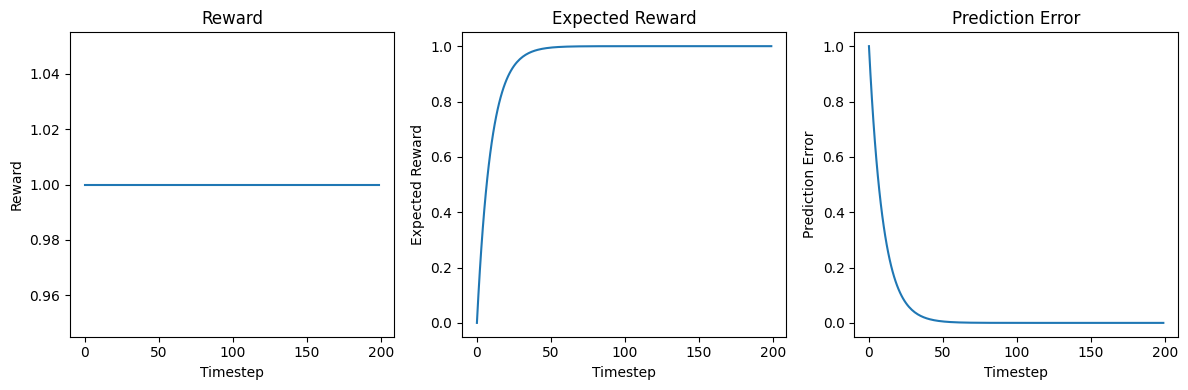

In [13]:
n_steps = 200
learning_rate = 0.1
reward_amount = 1.
v_init = 0.

env = PavlovsEnvironment(reward_amount)
agent = RescorlaWagnerAgent(v_init=v_init, learning_rate=learning_rate)

data_to_plot = run_pavlovian_learning(env, agent, n_steps)

_ = plot_learning_variables_over_time(data_to_plot)
plt.tight_layout()

#### Exercises
1. What happens to the Expected Reward $v$ over time? What about the prediction error $\delta$?
2. What happens if you change learning_rate to 0? 1? 0.01?
3. What happens if you change v_init to 1? 2?
4. *Thought experiment:* what would happen if reward was probabilistic (ie you got reward 50% of the time)? What would expected reward be? Would prediction errors ever go down to 0?

## Learning about multiple stimuli

We motivated Rescorla-Wagner agent with blocking. Let's see if blocking really works. This means we have to extending the agent we defined above so it can learn about multiple stimuli at the same time: instead of learning a single association $v$ for expected reward, we'll learn multiple associations $w_i$ which each convey the expected reward associated with some different stimulus $s_i$ (such as light, tone, smell, taste, etc).

The new update for $w_i$ will look like this:

$$ w_i \leftarrow w_i + \alpha \delta$$

$$ \delta = r - \sum_i w_i s_i$$

* $w(s)$: expected reward associated with each stimulus $s$.
* $s_i$: stimulus
* $r$: reward that was experienced.
* $\sum_i w_i s_i$: the expected reward, computed by multiplying all present stimuli $s_i$ by their associations $w_i$ and summing them up.
* $\delta$: the prediction error $r-\sum_i w_i s_i$, the difference between the actual reward $r$ and expected reward $v$.
* $\alpha$: learning rate between 0 and 1 that scales how much value is updated following reward.

#### Exercise
In the below cell, you will write the update function for a Rescorla-Wagner agent that takes in multiple stimuli. Fill in the lines of code marked `*Exercise*`

In [11]:
class RescorlaWagnerAgentMultipleStim(BaseAgent):
  """Agent that implements Rescorla-Wagner learning over multiple stimuli simultaneously.
  
  Instead of keeping track of a single variable, V, the expected reward, this agent will 
  keep track of multiple weights, w_i, each corresponding to a different stimulus dimension
  (e.g. light and sound). Each w_i is updated track the expected reward associated with each
  stimulus dimension. Expected reward is computed by multiplying each stimulus present by 
  its corresponding weight then summing to get total expected reward.
  """
  def __init__(self, n_stim: int, w_init: float, learning_rate: float = 0.1,
               name: str = 'Rescorla Wagner Multi Stim'):
    """Initialize.

    Args:
      n_stim: the number of stimulus dimensions to learn associations for
      w_init: float containing initial association between a stimulus dimension and reward
      learning_rate: float, determines how quickly you update expectations (alpha)
    """
    # Save params.
    self.n_stim = n_stim
    self.w = np.array([w_init] * n_stim)  # an array of length n_stim containing w_init
    self.alpha = learning_rate

    # Save variables to track.
    self.variables_to_track = [
      'Reward', 'Total Expected Reward', 'Prediction Error','Expected Reward per Stim', 'Stimuli']
    self.history = {k: [] for k in self.variables_to_track}
    super().__init__(name=name)

  def update(self, reward, stimuli):
    """Function that implements R-W update for observations containing multiple stimuli.

    Args:
      reward: scalar, the actually observed reward from the environment (R)
      expected_reward_per_stimulus:  array with length n_stimuli containing the
        expected reward associated with each stimulus feature
      stimuli: array with length n_stimuli containing stimuli present on this trial
    """
    # Check that there are as many stimulus dimensions as association weights to update.
    assert len(self.w) == len(stimuli)

    # Keep track of variables before update.
    self.history['Expected Reward per Stim'].append(self.w.copy())
    self.history['Reward'].append(reward)
    self.history['Stimuli'].append(stimuli)

    # # *Exercise*.
    # # Compute expected reward.
    # v = ...

    # # Update expected reward, self.v, using prediction error (aka delta).
    # prediction_error = ...

    # # Update association weights, self.w
    # self.w = ...

    # *Solution*.
    # Compute expected reward.
    v = np.sum(self.w * stimuli)

    # Update expected reward, self.v, using prediction error (aka delta).
    prediction_error = reward - v

    # Update association weights, self.w
    self.w += self.alpha * prediction_error * stimuli

    self.prediction_error = prediction_error

    # Keep track of variables after update.
    self.history['Total Expected Reward'].append(v)
    self.history['Prediction Error'].append(prediction_error)


In [12]:
n_stim = 2
learning_rate = 0.1
w_init = 0.
stim = np.array([1, 0])  # First stimulus is present, second is not.

agent = RescorlaWagnerAgentMultipleStim(n_stim, w_init, learning_rate)

print(f'Initial agent.w: {agent.w}')

agent.update(1, stim)

print(f'agent.w: {agent.w}')
print(f'agent.prediction_error: {agent.prediction_error}')


Initial agent.w: [0. 0.]
agent.w: [0.1 0. ]
agent.prediction_error: 1.0


#### Exercise
1. Check that your agent runs without error. 
2. Which entries in `agent.w` were updated? What happens if you change `stim` to `np.array([0, 1])` or `np.array([1, 1])`?


## Gaussian Environment
We'll start exploring our agent in a simple two-stimulus environment with probabilistic reward. The environment randomly samples continuous values for two stimuli from a Gaussian.

$s_1, s_2 \sim \mathcal{N}(0, 1)$

It then computes reward as:

$r = v_1s_1 + v_2s_2 + \epsilon$

where $v_1, v_2$ are stimulus values conveyed in `reward_per_stim`, and $\epsilon$ is randomly sampled from a Gaussian $\epsilon \sim \mathcal{N}(0, \sigma)$ where $\sigma$ is `reward_noise`.

We will use this environment to test the agent we wrote in the above cell. We have defined this for you below -- have a look, but we don't need to fill in any code here.

In [13]:
class TwoStimEnv(BaseEnv):
  """Environment that samples Gaussian stimuli and returns probabilistic reward."""

  def __init__(self, reward_per_stim: np.ndarray, reward_noise: Optional[float] = None):
    """Initialize.
    
    Args:
      reward_per_stim: array that has length n_stim with average reward per stimulus feature
      reward_noise: the noise added to the sampled rewards.
    """
    self.reward_per_stim = np.array(reward_per_stim)
    self.reward_noise = reward_noise if reward_noise else np.mean(np.abs(self.reward_per_stim))/10
    self.n_stim = len(reward_per_stim)
    super().__init__()

  def step(self):
    # Sample a random set of positive stimulus values, each from a squared unit Gaussian.
    stimuli = np.random.randn(self.n_stim)

    # Compute the reward for this stimulus
    reward = np.sum(self.reward_per_stim * stimuli)

    # Add a little bit of noise (if self.reward_noise > 0)
    noise = np.random.randn() * self.reward_noise
    reward += noise

    return reward, stimuli


Below is another function for setting up an RL loop (what's different compared to `run_pavlovian_agent`?).

In [14]:
def run_pavlovian_multistim_agent(env, agent, n_steps):
  for tstep in range(n_steps):
    reward, stimuli = env.step()
    agent.update(reward, stimuli)
  return agent.get_history_to_plot()

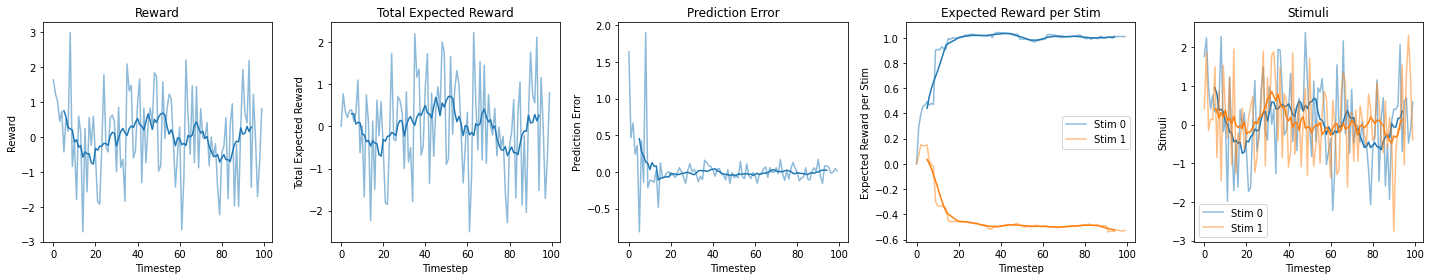

In [15]:
n_steps = 100
learning_rate = .1
reward_per_stim = np.array([1., -0.5])
reward_noise = 0.
n_stim = len(reward_per_stim)

env = TwoStimEnv(reward_per_stim, reward_noise=reward_noise)
agent = RescorlaWagnerAgentMultipleStim(n_stim=n_stim, w_init=0., learning_rate=learning_rate)

data_to_plot = run_pavlovian_multistim_agent(env, agent, n_steps)
fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=True, add_labels=True)
plt.tight_layout()

In [16]:
print(f'True reward_per_stim: {reward_per_stim}')
print(f'Learned agent.w: {agent.w}')

True reward_per_stim: [ 1.  -0.5]
Learned agent.w: [ 1.00961614 -0.5270242 ]


#### Exercise
1. Compare `reward_per_stim` to `agent.w`. Are they similar? Do you expect them to be?

### Blocking

We're now ready to try a blocking "experiment" on our agent!

#### Exercise
In the below cell, you'll create an Environment that runs a blocking experiment by filling in the `step()` function in the below cell.

Recall the structure of a blocking experiment:
1. For `n_steps_A`, the agent sees A alone (`np.array([1, 0])`), followed by reward
2. After that, the agent sees both A and B (`np.array([1, 1])`), followed by reward

In [17]:
class BlockingEnv(BaseEnv):
  """A single stimulus is paired with the US (A --> R), then a compound stimulus is paired with the US (AB --> R)."""
  def __init__(self, n_steps_A: int = 100):
    """Initialize.
    
    Args:
      n_steps_A: the number of trials in which A is seen alone, followed by reward.
    """
    self.n_steps_A = n_steps_A
    self.n_stim = 2
    self.n_steps_elapsed = 0
    super().__init__()

  def step(self):
    # If tstep is less than the number of scheduled exposures to A, only A is present.
    # Otherwise, A and B are both present.

    # *Exercise:*
    # stimuli = ...
    # reward = ...

    # *Solution*
    if self.n_steps_elapsed < self.n_steps_A:
      stimuli = np.array([1, 0]) # Just stim A.
    else:
      stimuli = np.array([1, 1])  # Stim A and Stim B.
    
    # Reward is always 1.
    reward = 1.

    # Increment number of elapsed steps by 1.
    self.n_steps_elapsed += 1

    return reward, stimuli


First, make sure your environment runs and is returning sensible values.

In [18]:
n_steps_A = 100
env = BlockingEnv(n_steps_A=n_steps_A)
reward, stim = env.step()
print(f'reward: {reward}')
print(f'stim: {stim}')


reward: 1.0
stim: [1 0]


agent.w: [9.99986719e-01 1.32806994e-05]


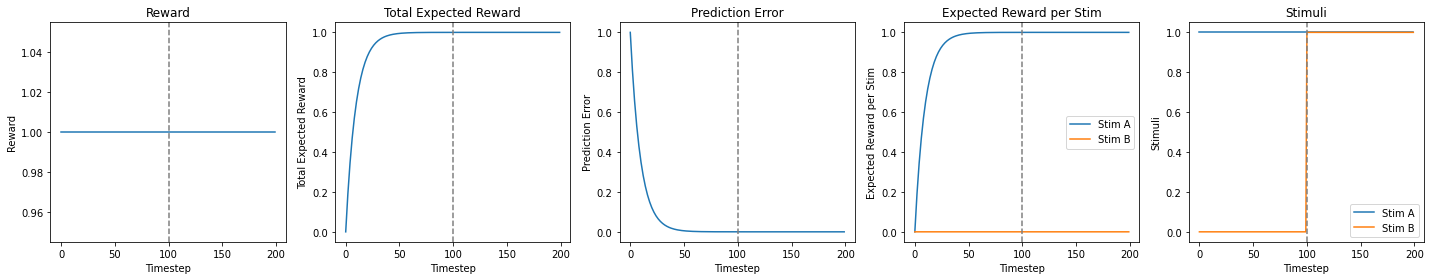

In [19]:
n_steps_A = 100
n_steps_AB = 100
n_steps = n_steps_A + n_steps_AB
learning_rate = 0.1
n_stim = len(reward_per_stim)

env = BlockingEnv(n_steps_A=n_steps_A)
agent = RescorlaWagnerAgentMultipleStim(n_stim=n_stim, w_init=0., learning_rate=learning_rate)

data_to_plot = run_pavlovian_multistim_agent(env, agent, n_steps)
fig, axes = plotting.plot_learning_variables_over_time(
  data_to_plot, show_smooth=False, add_labels=True, stim_labels=['Stim A', 'Stim B'])
plotting.add_vline(axes, n_steps_A, '--', color=plotting.GRAY)

plt.tight_layout()

print(f'agent.w: {agent.w}')

#### Exercises
1. Inspect the Stimuli plot (far right). What happens at x=n_steps_A on the plot?
2. Look at Expected Reward per Stim plot, and look at agent.w. Did any learning happen for Stim B?
3. What happens if you change n_steps_A to a smaller number? How does that effect Prediction Error and Expected Reward per Stim plots? What does that suggest about blocking?


#### Additional exercises.
Rescorla-Wagner models makes a number of other predictions about how learning can be altered. If there is time, start implementing some and see if you can capture some of these classic effects with your agent. These can have the same form as BlockingEnv. Solutions can be found in the solutions.ipynb notebook if you would like to experiment with these tasks later.

* `OvershadowingEnv`: Environment that returns two stimuli, by default one large (salient) and one small (not salient).
* `OverExpectationEnv`: Two stimuli are seperately paired with the US (A --> R, B --> R), then the compound stimulus is presented (AB --> ?)
* `ConditionedInhibition`: A single stimulus is paired with the US (A --> R) then a second stimulus is added and the reward is removed. (AB --> _).

For each of these environments, (1) pay attention to the far right plot (Stimuli) to confirm your experiment is working as expected. Then look at (2) what expectations converge to (3) how total expected reward changes and stimulus-wise expectations over time, particularly at events and (4) how prediction errors change over time. 

In [20]:
class OverShadowingEnv(BaseEnv):
  """Environment that returns two stimuli, by default one large (salient) and one small (not salient)."""
  def __init__(self, stimuli: np.ndarray = np.array([1., 0.1])):
    self.stimuli = stimuli
    self.n_stim = 2
    self.n_steps_elapsed = 0
    super().__init__()

  def step(self):
    stimuli = self.stimuli
    reward = 1
    return reward, stimuli

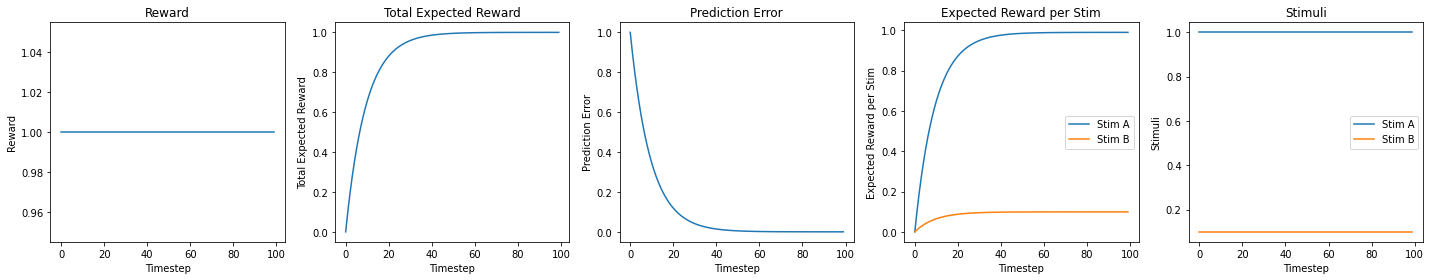

In [21]:
n_steps = 100
stimuli = np.array([1., 0.1])
learning_rate = 0.1
n_stim = len(stimuli)

env = OverShadowingEnv(stimuli)
agent = RescorlaWagnerAgentMultipleStim(n_stim=n_stim, w_init=0., learning_rate=learning_rate)

data_to_plot = run_pavlovian_multistim_agent(env, agent, n_steps)
fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=False, add_labels=True, stim_labels=['Stim A', 'Stim B'])  
plt.tight_layout()


#### Exercise
Try different values for the two stimuli. How does this effect the expected reward per stim?

Do these values make sense?

Are there alternate values the agent could have assigned to these stimuli that would have given equally valid predictions?

In [22]:
class OverExpectation(BaseEnv):
  """Two stimuli are seperately paired with the US (A --> R, B --> R), then the compound stimulus is presented (AB --> ?)."""
  def __init__(self, n_steps_separate: int = 100):
    self.n_steps_separate = n_steps_separate
    self.n_stim = 2
    self.n_steps_elapsed = 0
    super().__init__()

  def step(self):
    # If tstep is less than n_steps_separate, randomly sample either A or B but not both.

    if self.n_steps_elapsed < self.n_steps_separate:
      stimulus = np.random.randint(self.n_stim)
      stimuli = np.eye(self.n_stim)[stimulus]  # Convert to one-hot (aka 1 -> [0, 1, 0, 0, ...])
    else:
      stimuli = np.ones(self.n_stim)

    reward = 1.
    self.n_steps_elapsed += 1
    return reward, stimuli

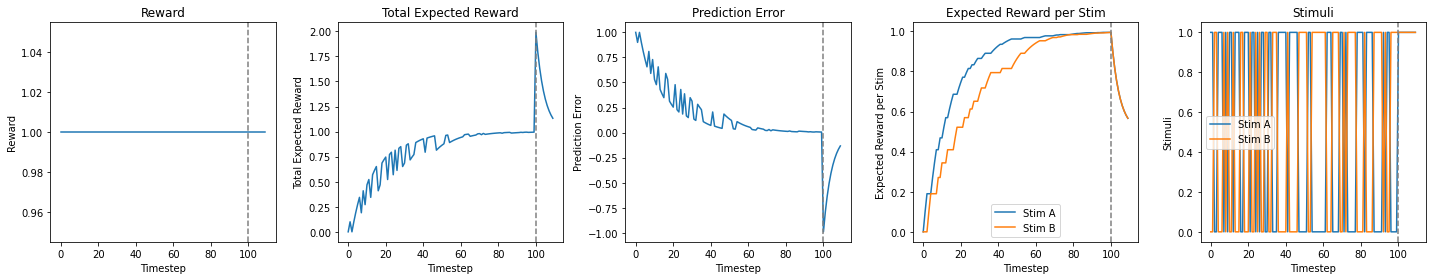

In [23]:
n_steps_separate = 100
n_steps = n_steps_separate + 10
learning_rate = 0.1
n_stim = 2
w_init = 0.

env = OverExpectation(n_steps_separate)
agent = RescorlaWagnerAgentMultipleStim(n_stim=n_stim, w_init=w_init, learning_rate=learning_rate)

data_to_plot = run_pavlovian_multistim_agent(env, agent, n_steps)
fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=False, add_labels=True, stim_labels=['Stim A', 'Stim B'])
plotting.add_vline(axes, n_steps_separate, '--', color=plotting.GRAY)
plt.tight_layout()


In [24]:
class ConditionedInhibition(BaseEnv):
  """A single stimulus is paired with the US (A --> R) then a second stimulus is added and the reward is removed. (AB --> _)."""
  def __init__(self, n_steps_A: int = 100):
    self.n_steps_A = n_steps_A
    self.n_stim = 2
    self.n_steps_elapsed = 0
    super().__init__()

  def step(self):
    stimuli = np.zeros(self.n_stim)
    if self.n_steps_elapsed < self.n_steps_A:
      stimuli[0] = 1  # Only A
      reward = 1.
    else:
      stimuli[:2] = 1  # A and B
      reward = 0.
    self.n_steps_elapsed += 1
    return reward, stimuli

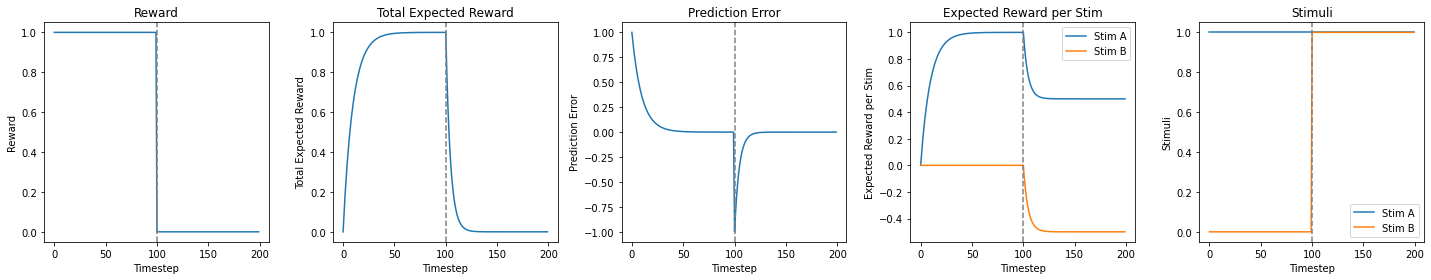

In [25]:
n_steps_A = 100
n_steps_AB = 100
n_steps = n_steps_A + n_steps_AB
learning_rate = 0.1
n_stim = 2
w_init = 0.

env = ConditionedInhibition(n_steps_A=n_steps_A)
agent = RescorlaWagnerAgentMultipleStim(n_stim=n_stim, w_init=w_init, learning_rate=learning_rate)

data_to_plot = run_pavlovian_multistim_agent(env, agent, n_steps)
fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=False, add_labels=True, stim_labels=['Stim A', 'Stim B'])
plotting.add_vline(axes, n_steps_A, '--', color=plotting.GRAY)
plt.tight_layout()


# 2. Making Good Choices


Section 1 covered expectations: how to learn to predict reward (which is an important part of learning how to maximize it). But, in the Pavlovian conditioning examples above, the agent does not actually get to make any choices, or take actions to *affect* reward. And of course that is something agents and animals can usually do (otherwise, there is arguably not much of a point to being able to predict anything). We'll now cover Instrumental Learning", where, in contrast to Pavlovian Conditioning, covers experiments where animals (or agents) can make choices.

We'll study this in the context of a task called the $n$-armed bandit tasks. This comes from a nickname for slot machines (since they have an "arm" you can pull, and they steal your money like a bandit).

Say you are at a casino and there are $n$ "arms" available to you. 

<center><img src="./figures/bandits.png" width=500></center>

Each arm delivers reward with some probability, which you don't know. The only way to learn about the rewards is to try them. 

What strategy do you use to sample arms, given that you want to learn as much as you can about the different arms, while also not wasting time on suboptimal arms?

## Probabilistic reward.
The experiments we will work with in the following section will involve probabilistic reward. We will define a function `sample_reward` to sample binary rewards (ie rewards that are either 0 or 1) with a specified probability.


In [26]:
def sample_reward(prob):
  """Sample from a binomial (weighted coin flip) with probability prob."""
  if (prob < 0) or (prob > 1):
    raise ValueError(f'Probability must remain between 0 and 1. prob={prob} not valid.')
  random_number = np.random.rand()  # Sample random number between 0 and 1
  if random_number < prob:  # return 1 with probability = prob
    return 1
  else:                     # otherwise return 0
    return 0


def test_sample_reward():
  prob = 0.5  # Play around with different values here.
  n_samples = 10  # Play around with different values here.
  rewards = []
  for i in range(n_samples):
    reward = sample_reward(prob)
    print(f'Trial {i} reward = {reward}')
    rewards.append(reward)
  mean_reward = np.mean(rewards)
  print(f'Mean reward = {mean_reward}')

test_sample_reward()


Trial 0 reward = 0
Trial 1 reward = 1
Trial 2 reward = 1
Trial 3 reward = 0
Trial 4 reward = 0
Trial 5 reward = 1
Trial 6 reward = 1
Trial 7 reward = 1
Trial 8 reward = 0
Trial 9 reward = 0
Mean reward = 0.5


#### Exercise
Experiment by setting different `prob` and `n_samples`. What is the relationship between `prob`, `n_samples`, and `mean_reward`?

### N-Armed Bandit
Here, we set up an n-armed bandit environment using sample_reward function. This environment takes in an array of reward probabilities with lenght equal to the number of arms, such that `reward_probabilities[action]` returns the probability that the chosen action will lead to reward.

The `step` function of this environment will take in an action (aka a choice in "arm"), compute the reward probability for the action, and then sample a reward with the probability.

#### Exercise
You will fill in the missing code in `NArmedBanditEnv` to select the correct probability and sample a reward.

In [27]:
class NArmedBanditEnv(BaseEnv):
  """N-armed bandit environment."""

  def __init__(self, reward_probabilities: np.ndarray):
    """Initialize.

    Args:
      reward_probabilities: an array that has length n_arms, with values
        between 0 and 1 (inclusive). It specifies the probability of reward
        for each action.
    """
    self.reward_probabilities = np.array(reward_probabilities)
    self.n_actions = len(reward_probabilities)

    if len(self.reward_probabilities.shape) > 1:
       rp_shape = self.reward_probabilities.shape
       raise ValueError(
          f'reward_probabilities should be a one dimensional array. Found shape={rp_shape}')

  def step(self, action: int):
    """Get reward for the arm the agent selected.

    Args:
      action: an integer specifying which an action (aka which arm) was
        chosen by the agent.

    Returns:
      reward: an integer (either 0 or 1) specifying the received reward.
    """
    if action > self.n_actions:
        raise ValueError(f'Action {action} is greater than the number of arms {self.n_actions}')

    # *Exercise*
    # reward_probability = ...
    # reward = ...

    # *Solution*
    reward_probability = self.reward_probabilities[action]
    reward = sample_reward(reward_probability)
    return reward


#### Exercise
1. Confirm your environment runs without error.
2. Experiment with different `rewardprobabilities` and different values for `n_arms` to confirm the environment is working as expected.


In [28]:
n_arms = 2
n_steps = 5
reward_probabilities = np.array([0.1, 0.9])
env = NArmedBanditEnv(reward_probabilities)

for _ in range(n_steps):
  reward = env.step(action=0)
  print(f'action = 0, reward = {reward}')
print()
for _ in range(n_steps):
  reward = env.step(action=1)
  print(f'action = 1, reward = {reward}')

action = 0, reward = 0
action = 0, reward = 0
action = 0, reward = 0
action = 0, reward = 0
action = 0, reward = 0

action = 1, reward = 1
action = 1, reward = 0
action = 1, reward = 1
action = 1, reward = 1
action = 1, reward = 1


### Q-Learning

Now we turn our attention to the agent. We'll implement a learning algorithm called "Q-learning".

Q-learning involves learning the expected reward associated with each action. It's called Q-learning because it involves learning Q-values, which refers to the expected reward associated with an action (I do not know why they are called Q-values). 

So notationally, $Q(a)$ is the expected reward associated with an action.

#### Updating Q
We learn Q-values with the same error-driven learning we used in Rescorla-Wagner, but now it is conditional on action $a$. So instead of $v(s) \leftarrow v(s) + \alpha \delta$, we'll have...

$Q(a) \leftarrow Q(a) + \alpha \delta(a)$

$\delta(a) = r - Q(a)$

Where $a$ is action, $Q(a)$ is the expected value of $a$, $r$ is reward, $\alpha$ is learning rate, and $\delta$ refers to the prediction error. 

#### Choosing actions
For now, we'll choose actions with a "greedy policy", which means we will just pick whichever action has the largest q-value associated with it. This will not turn out to be a very good idea, but we'll get to that.


#### Exercise
Below, we've defined a function `greedy_choice` that takes in an array of q-values, and returns the action with the highest q-value (or, if there is a tie, it will randomly sample one of the best). Below that is an agent called `GreedyQAgent`, which uses greedy_choice to an action. 

Fill in the lines of code marked `*Exercise*` in the update function.

In [29]:
def greedy_choice(q: np.ndarray):
  """Return an action with the maximum estimated reward probability."""
  # Get action(s) with maximum q.
  q_max = np.max(q)
  best_actions = np.argwhere(q == q_max).reshape(-1)

  # Sample randomly from any top actions.
  action = np.random.choice(best_actions)
  return action


class GreedyQAgent(BaseAgent):
  """Q-learning agent that always selects the most rewarding action."""

  def __init__(self, n_actions: int, q_init: float, learning_rate: float,
               name: str = 'Greedy Q-Learning'):
    """Initialize.

    Args:
      n_actions: number of actions available to the agent
      q_init: float indicating the initial q-value associated with each action.
      learning_rate: learning rate with which q-values are updated.
    """
    self.n_actions = n_actions
    self.q = np.array([q_init] * n_actions, dtype=float)
    self.alpha = learning_rate
    self.variables_to_track = ['Reward', 'Prediction Error', 'Q-Values', 'Action']
    self.history = {k: [] for k in self.variables_to_track}
    super().__init__(name=name)

  def update(self, reward, action):
    """Get reward for the arm the agent selected.

    Args:
      reward: an integer (either 0 or 1) specifying the received reward.
      action: an integer specifying which an action (aka which arm) was
        chosen by the agent.
    """
    if action > self.n_actions:
        raise ValueError(f'Action {action} is greater than the number of arms {self.n_actions}')

    # Keep track of variables before update.
    self.history['Q-Values'].append(self.q.copy())
    self.history['Reward'].append(reward)
    self.history['Action'].append(action)

    # # *Exercise*
    # # Get expected reward.
    # v = ...

    # # Update expected reward, self.v, using prediction error (aka delta).
    # prediction_error = ...

    # # Update association weights, self.w
    # self.q[action] += ...

    # *Solution*
    # Get expected reward.
    v = self.q[action]

    # Update expected reward, self.v, using prediction error (aka delta).
    prediction_error = reward - v

    # Update association weights, self.w
    self.q[action] += self.alpha * prediction_error

    self.prediction_error = prediction_error

    # Keep track of variables after update.
    self.history['Prediction Error'].append(prediction_error)

  def choose_action(self):
    """Return the action with the highest estimated reward probability."""
    return greedy_choice(self.q)

  def total_reward(self):
    return np.sum(self.history['Reward'])

  def rate_of_reward(self):
    return np.mean(self.history['Reward'])
    

#### Exercise
Confirm that your agent runs without error, and that it picks the most rewarding arm

In [30]:
n_actions = 3
q_init = 0.
learning_rate = 0.1
agent = GreedyQAgent(n_actions, q_init, learning_rate)
action = agent.choose_action()
reward = 1.
agent.update(reward, action)
print(f'agent.q: {agent.q}')
print(f'agent.prediction_error: {agent.prediction_error}')

# Force agent.q to be [0, 1, 0] and confirm that it selects the most rewarding action (action=1)
forced_best_action = 1
agent.q = np.zeros(n_actions)
agent.q[forced_best_action] = 1
action = agent.choose_action()
print(f'action={action} (should be {forced_best_action}, otherwise there is likely an error)')

agent.q: [0.1 0.  0. ]
agent.prediction_error: 1.0
action=1 (should be 1, otherwise there is likely an error)


Set up an RL learning loop with the agent taking in rewards and outputting actions, and the environment taking in actions and outputting rewards.

In [31]:
def run_qagent_bandit(env, agent, n_steps):

  for tstep in range(n_steps):
    action = agent.choose_action()  # Agent chooses an action
    reward = env.step(action)  # Environment offers an action
    agent.update(reward, action)  # Agent updates its expectations

  return agent.get_history_to_plot()

Now, let's see how our agent does on a 6-armed bandit task with `reward_probabilities = [0, 0.2, 0.4, 0.6, 0.8, 1.0]`

Note that the "worst" action here is action =  (the first choice in the list), and the "best" action here is action=5 (the last choice in the list).

agent.q [0.         0.         0.         0.41276531 0.         0.        ]
estimated best_arm: 3
Total reward: 57 (max possible=100)
Rate of reward: 0.57 (max possible=1)
Action counts: {0: 0, 1: 1, 2: 0, 3: 99, 4: 0}


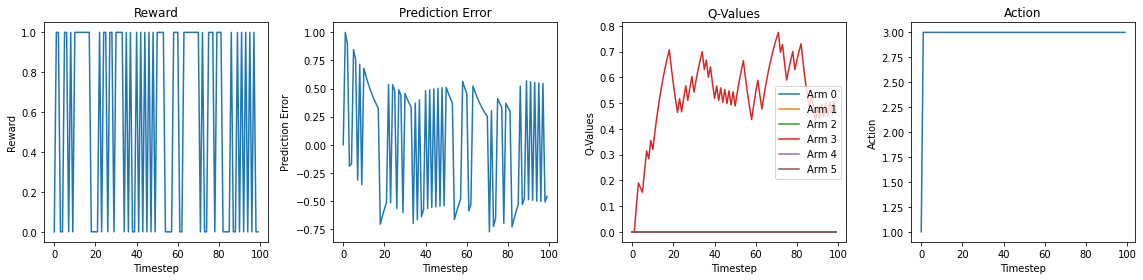

In [32]:
n_steps = 100
reward_probabilities = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
n_arms = len(reward_probabilities)
q_init = 0.
agent = GreedyQAgent(n_arms, q_init, learning_rate=0.1)
env = NArmedBanditEnv(reward_probabilities)

data_to_plot = run_qagent_bandit(env, agent, n_steps)

fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=False, add_labels=True, 
                                                       stim_labels=[f'Arm {i}' for i in range(n_arms)])
plt.tight_layout()

print(f'agent.q {agent.q}')
print(f'estimated best_arm: {np.argmax(agent.q)}')
print(f'Total reward: {agent.total_reward()} (max possible={n_steps})')
print(f'Rate of reward: {agent.rate_of_reward()} (max possible=1)')

counts, _ = np.histogram(agent.history['Action'], bins=range(agent.n_actions))
counts = {a: c for a, c in enumerate(counts)}
print(f'Action counts: {counts}')

#### Exercises
1. Which arm does your agent converge on as the "best arm"? 
2. Look at the "Action" plot. Did your agent explore more than one arm?
3. Try running the above cell a few times -- does the agent always pick the same "best arm"? Does it usually get the correct "best arm" (5)? Does it ever get the worst arm (0)?


## Explore-Exploit Tradeoff

Likely what you saw in the above cell is that the agent stayed with the first arm that gave any reward. This is because after that first experience with reward, the updated Q-value for the chosen action is incremented to be larger than all the other values. Since the agent is always picking the action it thinks is best, it never explores the other actions. If it did, it would eventually learn that there are better arms out there.

This illustrates a fundamental tension in RL: the Explore-Exploit tradeoff. If you have a policy of only picking the action with the highest current estimated Q-value, you lose an opportunity to get information about other outcomes. But if you waste too much time sampling actions that don't have a high estimated value, you are wasting actions you could be spending cashing in on more rewarding arms. Such is life.


### Optimistic Initialization
We're going to learn some strategies for dealing with this. First, we're going to return to the above cell and try a simple strategy called **optimistic initialization.** Optimistic initialization means picking an optimistic value for `q_init`: a value higher than you're likely to actually experience most of the time. This means that more experience with the environment will likely lower your q-values (unless the action truly is really good). This gives an artificial bonus to actions that have not been explored. 

#### Exercise
* Return to the above cell, and chance q_init to 1. 
* Does your agent find the correct best_action now?
* How do the learned Q-values compare to the true values?

### Epsilon-Greedy Q-learning
Another strategy for managing the explore-exploit tradeoff is to decide to choose a random action sometimes. $\epsilon$-greedy means that with probability $\epsilon$, you randomly chose an action. Otherwise, you pick the best action.

#### Exercise
Below is an agent `EpsilonGreedyQAgent` based on the `GreedyQAgent`. You will modify `choose_action` to implement the $\epsilon$-greedy action selection policy.  

In [33]:
class EpsilonGreedyQAgent(GreedyQAgent):
  """Q-learning agent that always selects the most rewarding action."""

  def __init__(self, n_actions: int, q_init: float, learning_rate: float, epsilon: float,
               name: str = 'Epsilon Greedy Q-Learning'):
    """Initialize.

    Args:
      n_actions: integer indicating the number of available actions.
      q_init: float indicating the initial q-value associated with each action.
      learning_rate: learning rate with which q-values are updated.
      epsilon: float indicating probability of taking a random exploratory action
    """
    super().__init__(n_actions=n_actions, q_init=q_init, learning_rate=learning_rate,
                     name=name)
    self.epsilon = epsilon

  def choose_action(self):
    """Return the action with an epsilon-greedy policy."""
    # # *Exercise*
    # aciton = ...
    # return action

    # *Solution*
    do_explore = np.random.rand() < self.epsilon

    # Explore: select random action.
    if do_explore:
      action = np.random.randint(self.n_actions)

    # "Exploit": Select greedy action
    else:
      action = greedy_choice(self.q)
    return action

#### Exercise
1. Run the below cell to confirm the agent is working.
2. Test your code with epsilon=0, epsilon=1, and epsilons in between. When epsilon is zero, you should always chose action 0. As epsilon approaches 1, action choice should become more random. 

In [34]:
epsilon = 0.
agent = EpsilonGreedyQAgent(n_actions=2, q_init=0., learning_rate=0.1, epsilon=epsilon)

# Update the value of action 0 so it is the highest.
action = 0
agent.update(reward=1, action=action)
agent.prediction_error
action = agent.choose_action()
print(f'action: {action} (should be action={action} if epsilon is 0, and 100% random if epsilon is 1')

action: 0 (should be action=0 if epsilon is 0, and 100% random if epsilon is 1


#### Exercise
Now we'll revist the 6-armed bandit problem (below).

agent.q [0.         0.02541866 0.27005449 0.70258355 0.64581342 1.        ]
estimated best_arm: 5
Total reward: 956 (max possible=1000)
Rate of reward: 0.956 (max possible=1)
Action counts: {0: 15, 1: 14, 2: 17, 3: 17, 4: 937}


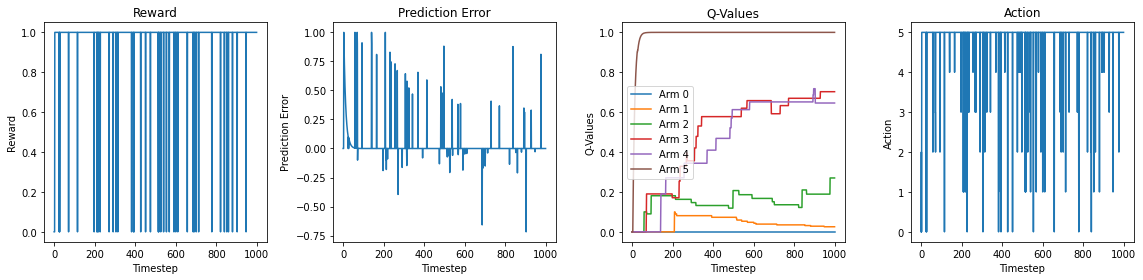

In [35]:
n_steps = 1000
reward_probabilities = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
n_arms = len(reward_probabilities)
q_init = 0.
epsilon = 0.1
agent = EpsilonGreedyQAgent(n_arms, q_init, learning_rate=0.1, epsilon=epsilon)
env = NArmedBanditEnv(reward_probabilities)


data_to_plot = run_qagent_bandit(env, agent, n_steps)

fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=False, add_labels=True, 
                                                       stim_labels=[f'Arm {i}' for i in range(n_arms)])
plt.tight_layout()

print(f'agent.q {agent.q}')
print(f'estimated best_arm: {np.argmax(agent.q)}')
print(f'Total reward: {agent.total_reward()} (max possible={n_steps})')
print(f'Rate of reward: {agent.rate_of_reward()} (max possible=1)')

counts, _ = np.histogram(agent.history['Action'], bins=range(agent.n_actions))
counts = {a: c for a, c in enumerate(counts)}
print(f'Action counts: {counts}')

#### Exercises
1. Does the agent sample a variety of actions, and eventually find the correct action? How does total reward compare to GreedyQAgent?
2. Experiment with different values of epsilon [0, 0.01, .1, 1.].
    * Which values of epsilon allow q-values to converge faster: larger or smaller values? 
    * Which values lead to the most total reward: 0, 1, or something in-between? 
    * When $\epsilon$ is 0, does the agent behave any differently from `GreedyQAgent`?
3. (Thought experiment) How would you find the optimal epsilon? Is there a single optimal epsilon, or does it depend on the task?

### Softmax Exploration
Finally, we'll explore one more popular exploration strategy: softmax-greedy exploration. Like $\epsilon$-greedy, softmax-greedy will sometimes chose actions not currently estimated to be optimal. $\epsilon$-greedy will randomly pick from all sub-optimal actions when it is exploring: it makes no distinction between the second-best and worst action.

Softmax greedy samples actios with a probability that increases with the q-value of the action, so that exploratory actions prioritize actions that are also estimated to high value. The softmax equation is:

$$
p(a) = \frac{e^{\beta q(a)}}{\sum_a e^{\beta q(a)}}
$$

where $a$ is action, $q(a)$ is the expected action value, $\beta$ is an exploration parameter called the inverse temperature parameter (terminology is borrowed from physics). Below is an illustration of action probabilities for different values of $\beta$ and $\epsilon$.

<center><img src="./figures/epsilon_v_softmax.png" width=500></center>

Smaller values for $\beta$ mean more exploration (for $\beta=0$, p(a) is uniform same for all actions, just like when $\epsilon=1$). As $\beta$ grows to infinity, the agent will approach a greedy policy (just like when $\epsilon=0$). For in-between values, softmax and $\epsilon$-greedy differ: softmax varies smoothly.


We have implemented the agent below, and will explore its behavior in the following cell.

##

In [36]:
def softmax(x):
  """Applies the softmax function."""
  return np.exp(x) / np.sum(np.exp(x))


def sample_from_multinomial(probs):
  """Samples from a probability distribution."""
  return int(np.random.choice(range(len(probs)), size=(), p=probs))


class SoftmaxGreedyQAgent(GreedyQAgent):
  """Q-learning agent that always selects the most rewarding action."""

  def __init__(self, n_actions: int, q_init: float, learning_rate: float, beta: float,
               name: str = 'Softmax Greedy Q Agent'):
    """Initialize.

    Args:
      n_actions: integer specifying number of actions available.
      q_init: an array that has length n_arms, which has the initial
        estimates for the value of each arm.
      learning_rate: learning rate with which q-values are updated.
      beta: float indicating the softmax inverse temperature parameter.
    """
    super().__init__(n_actions=n_actions, q_init=q_init, learning_rate=learning_rate,
                     name=name)
    self.beta = beta

  def choose_action(self):
    """Return the action according to a softmax-greedy policy"""
    choice_probs = softmax(self.beta * self.q)
    action = sample_from_multinomial(choice_probs)
    return action

agent.q [0.         0.2618013  0.27878028 0.56370263 0.96949552 0.99999999]
estimated best_arm: 5
Total reward: 514 (max possible=1000)
Rate of reward: 0.514 (max possible=1)
Action counts: {0: 154, 1: 175, 2: 160, 3: 168, 4: 343}


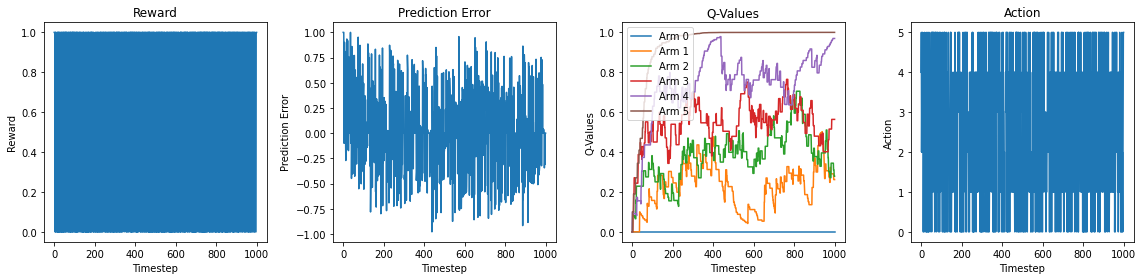

In [37]:
n_steps = 1000
reward_probabilities = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
n_arms = len(reward_probabilities)
q_init = 0.
agent = SoftmaxGreedyQAgent(n_actions=n_arms, q_init=q_init, learning_rate=0.1, beta=0)
action = agent.choose_action()
env = NArmedBanditEnv(reward_probabilities)


data_to_plot = run_qagent_bandit(env, agent, n_steps)

fig, axes = plotting.plot_learning_variables_over_time(data_to_plot, show_smooth=False, add_labels=True, 
                                                       stim_labels=[f'Arm {i}' for i in range(n_arms)])
plt.tight_layout()

print(f'agent.q {agent.q}')
print(f'estimated best_arm: {np.argmax(agent.q)}')
print(f'Total reward: {agent.total_reward()} (max possible={n_steps})')
print(f'Rate of reward: {agent.rate_of_reward()} (max possible=1)')

counts, _ = np.histogram(agent.history['Action'], bins=range(agent.n_actions))
counts = {a: c for a, c in enumerate(counts)}
print(f'Action counts: {counts}')

#### Exercises
How do the chosen actions (particularly the Action Counts) and learned q-values learned by the softmax greedy policies differ?

# 3. Foresight
## Incorporating future rewards into our plans.

Many decisions are about optimizing for future reward, rather than immediate reward. For instance, deciding to submit an application for a summer school is accepting short term discomfort (writing an application) in exchange for long-term reward (the thrill of learning about computational neuroscience!).

The final thing we consider will be how to adapt the RL process to include future expected reward.

This is typically modelled with Markov Decision Processes (MDPs), which capture an environment that has structure. An MDP contains multiple states, and actions influence not just reward but how the agent can transition through this environment.

Here we illustrate an MDP with three states, and 2 actions that move the agent between states. 

<center><img src="./figures/mdp.png" width=500></center>


This environment is linear: the agent can transition from state $s_n$ can transition to state $s_{n+1}$ with action $a=0$ and $s_{n-1}$ with action $a=1$ (except at the boundaries, where the agent stays in place if $s_{n+1}$ or $s_{n-1}$ is out of limits). The agent receives reward at the rightmost state $s_{N-1}$ (given $N$ states). In our experiments, the agent will start at the leftmost state $s_0$.

Below, we construct an MDP environment `MDPEnv`. This environment is specified with a reward function (`reward_amounts`), transitions (`transitions`), as well as starting state `start_state` (and, optionally, absorbing states `absorb_states`). Here, we are assuming deterministic transitions, which means that the next state $s'$ is fully determined by current state $s$ and action $a$. 

We also show an example MDPEnv with 4-states arranged linearly (as in the illustration above) called `FourStateLinearMDPEnv`. We also include `LinearMDPEnv` which sets up linear MDP environments for an arbitrary number of states.

#### Exercise
Look at how the environments are set up. In particular look at how `FourStateLinearMDPEnv` sets up `transitions` and `reward_amounts`. There are no coding exercises in the next cell, simply an example of how the environment is set up to inspect.


In [38]:
class MDPEnv(BaseEnv):
  """N-armed bandit environment."""
  def __init__(self, reward_amounts, transitions, start_state: int,
               absorb_states = None, pos_for_plotting = None):
    """Initialize.

    Args:
      reward_amounts: a dict that has length n_states, with values
        between 0 and 1 (inclusive). It specifies the amount of reward
        received at each state. States not in this dict will default to 0 reward.
      transitions: dict containing possible transitions, in the form
        (state, action): next_state.
      start_state: integer identifying starting state.
      absorb_states: array of integers identifying which states are
        absorbing (meaning that landing on this state will end the episode).
        Default=None, meaning episode will go on forever.
      pos_for_plotting: n_states x 2 array with positions for states to be
        used for plotting (default = None, will default to line or
        spring_layout depending on transition structure).
    """

    self.reward_amounts = reward_amounts

    self.transitions = transitions
    self.start_state = start_state

    if absorb_states is None:
      self.absorb_states = []
    elif not np.iterable(absorb_states):
      self.absorb_states = [absorb_states]
    else:
      self.absorb_states = absorb_states

    self.actions = env_utils.list_actions(self.transitions)
    self.n_actions = len(self.actions)

    self.states = env_utils.list_states(self.transitions)
    self.n_states = len(self.states)

    # If any states are ommitted from reward_probabilities, fill in with 0.
    for k in list(set(self.states) - set(self.reward_amounts.keys())):
      self.reward_amounts[k] = 0

    self.graph = env_utils.transition_dict_to_networkx(self.transitions)
    self.pos_for_plotting = nx.spring_layout(self.graph, seed=0) if pos_for_plotting is None else pos_for_plotting

    self.state = start_state

  def step(self, action: int):
    """Get reward for the arm the agent selected.

    Args:
      action: an integer specifying which an action (aka which arm) was
        chosen by the agent.

    Returns:
      reward: an integer (either 0 or 1) specifying the received reward.
    """
    if action > self.n_actions:
        raise ValueError(f'Action {action} is greater than the number of arms {self.n_actions}')

    end_of_episode = self.state in self.absorb_states
    reward = self.reward_amounts[self.state]
    next_state = self.transitions[(self.state, action)]

    self.state = next_state

    return reward, next_state, end_of_episode

  def reset(self):
    self.state = self.start_state
    return self.state

  def plot_env(self, ax = None, node_size: Optional[int] = 300, vmin=None, vmax=None):
    g = self.graph
    pos = self.pos_for_plotting
    node_color = np.zeros(self.pos_for_plotting.shape[0])
    for s, r in self.reward_amounts.items():
      node_color[s] = r
    do_labels = self.n_states < 16
    vmin = vmin or node_color.min() - 0.2
    vmax = vmax or node_color.max() + 0.2
    plotting.plot_graph(
      self.graph, self.pos_for_plotting, ax=ax, node_color=node_color, node_size=node_size,
      vmin=vmin, vmax=vmax, cmap='gray_r', do_labels=do_labels)

@property
def n_states(self):
  return self.n_states

@property
def n_actions(self):
  return self.n_actions


class FourStateLinearMDPEnv(MDPEnv):
  """4-state linear MDP env with starting state in left-most state and reward in right-most."""

  def __init__(self):
    reward_amounts = {
       0: 0,
       1: 0,
       2: 0,
       3: 1,
    }

    transitions = {
        # (state, action): next_state
        # Increment state if "right" action (action=0) is chosen
        (0, 0): 1,
        (1, 0): 2,
        (2, 0): 3,
        (3, 0): 3,
        # Decrement state if "left" action (action=1) is chosen
        (0, 1): 0,
        (1, 1): 0,
        (2, 1): 1,
        (3, 1): 2,
    }

    pos_for_plotting = np.array([(i, 0) for i in range(4)])

    super().__init__(
      reward_amounts=reward_amounts,
      transitions=transitions,
      start_state=0,
      absorb_states=None,
      pos_for_plotting=pos_for_plotting)



class LinearMDPEnv(MDPEnv):
  """Linear MDP env with starting state in left-most state and reward in right-most."""

  def __init__(self, n_states: int):
    reward_amounts = {n_states-1: 1}

    transitions = {}
    # Update with transitions to the left.
    transitions.update({(s, 0): min(s+1, n_states-1) for s in range(n_states)})
    # Update with transitions to the right.
    transitions.update({(s, 1): max(s-1, 0) for s in range(n_states)})
    pos_for_plotting = np.array([(i, 0) for i in range(n_states)])

    super().__init__(
      reward_amounts=reward_amounts,
      transitions=transitions,
      start_state=0,
      absorb_states=None,
      pos_for_plotting=pos_for_plotting)


Plot the `FourStateLinearMDPEnv` MDP.

* Arrows denote possible transitions between states (action $a=0$ transitions right, $a=1$ transitions left).
* the agent receives reward when it reaches the dark gray state
* The agent starts in the left-most state

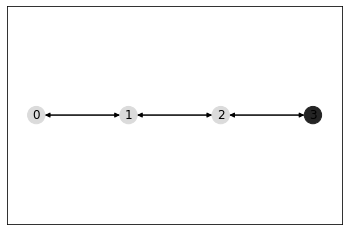

In [39]:
env = FourStateLinearMDPEnv()
env.plot_env()

#### Exercise
Plot the `LinearMDPEnv` MDP in the cell below. Vary `n_states` to see how the environment changes.

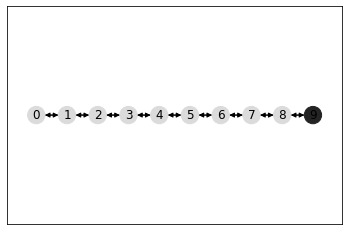

In [40]:
env = LinearMDPEnv(n_states=10)
env.plot_env()

#### Optional Exercise
If you are ahead of schedule, set up your own MDP, `MyMDPEnv` in the style of `FourStateLinearMDPEnv`. Replace the definitions of `self.transition` and `self.reward_amounts` with your own values.

In [41]:

class MyMDPEnv(MDPEnv):
  """Make up your own MDP to try with your agents."""

  def __init__(self):
    # reward_amounts = {
    #    state: reward_amount,
    # }

    # *Exercise
    reward_amounts = ...

    # transitions = {
    #     # (state, action): next_state
    # }

    # *Exercise
    transitions = ...

    pos_for_plotting = np.array([(i, 0) for i in range(4)])

    super().__init__(
      reward_amounts=reward_amounts,
      transitions=transitions,
      start_state=0,
      absorb_states=None,
      pos_for_plotting=pos_for_plotting)


# env = MyMDPEnv()
# env.plot_env



### Temporal Differences

MDPs are a framework for setting up environments with sequential structure: the agent's potential reward depends not just on its current state, but on future states it may occupy.

We now need to modify our learning algorithm so we are learning to incorporate future outcomes into its valuation. Intuitively, if state A has no reward, but eventually leads to a state B with high reward, state 1 should have some value as well because it *predicts future reward*. 

Thus we will define the value of a state $V(s)$ to be equal to the expected discounted future reward, where $\gamma$ is a discount factor between 0 and 1 that determines the planning horizon. A lower discount means the agent cares more about immediate than future reward. 

$$
V(s_t) = r(s_t) + \gamma r(s_{t+1}) + \gamma ^2 r(s_{t+2}) + ... = \sum_{i=0}^\infty r(s_{t+i})
$$

We can rearrange the parentheses and write this as...
$$
V(s_t) = r(s_t) + \gamma (r(s_{t+1}) + \gamma r(s_{t+2}) + ...) = r(s_t) + \gamma \sum_{i=0}^\infty r(s_{t+1+i})
$$

Since the rightmost term is the definition of value for state $s_{t+1}$, we can write our value function recursively! 

$$
V(s_t) = r(s_t) + \gamma V(s_{t+1})
$$

This equation is known as the **Bellman Equation.** One of the reasons it is exciting is that it enables us to incorporate future expected reward into error-driven learning. This is not trivial to do in the sequential context: how do we predict an error -- "actual" minus "predicted" -- when our "actual" term reward includes an unlimited sequence of future rewards which we haven't experienced yet? Turns out we can just replace the future reward terms with the current estimate for state value $V_t$. Even though this $V_t$ is something our agent is learning, and will be wrong at first, it will provably eventually converge to the right answer for $V$:

$$
V_{t+1}(s_t) \leftarrow V_t(s_t) + \alpha \delta
$$

$$
\delta = r(s_t) + \gamma V_t(s_{t_1}) - V_t(s_t)
$$



### Dopamine and Reward Prediction Errors

In a famous paper, Schultz, Dayan, and Montague (1997) show evidence that the firing of dopamine neurons appears to be consistent with DA neurons encoding a "reward prediction error", firing for unexpected but not expected reward.:

<center><img src="./figures/schultz.png" width=500></center>

This is the origin of the "Reward Prediction Error Hypothesis", which hypothesizes that dopamine encodes a reward prediction error that drives reward-driven learning in the cortex. This has spawned lots of work expressing more complex variants of dopaminergic reward driven learning that seek to explain more of the variability and complexity in the dopamine signal.

## Q-Learning agent.

To incorporate action selection into the learning process, we replace state value $V(s)$ with Q-values $Q(s, a)$, which learn the expected value not just of a state but of state-action pairs. We also replace the next-state value term $V_t(s_{t+1})$ with $\max_a Q(s_{t+1}, a)$. This, intuitively, is making the implicit assumption that the agent will chose the most rewarding next action from state $s_{t+1}$, which is a good assumption if you've got an optimal agent (or are trying to learn one).

$$
Q_{t+1}(s_t, a_t) \leftarrow Q_t(s_t, a_t) + \alpha \delta
$$

$$
\delta = r(s_t) + \gamma \max_a Q_t(s_{t+1}, a) - Q_t(s_t, a_t)
$$

#### Exercise
Implement a q-learning update in the following agent by filling in portions of the code marked `*Exercise*`

In [42]:
class QLearningTDAgent(BaseAgent):
  """Implement Q-learning agent."""

  def __init__(self, n_states: int, n_actions: int, q_init: float, learning_rate: float,
               epsilon: float, discount: float, name='Q-Learning TD Agent'):
    """Initialize.

    Args:
      n_states: number of states
      n_actions: number of actions
      q_init: float indicating initial value for each state, action pair.
      learning_rate: learning rate with which q-values are updated.
      epsilon: exploration parameter for epsilon-greedy (randomly "explore" with
        probability epsilon)
      discount: discount factor in [0, 1) range used to scale future reward
        (0 = only immediate reward matters, 0.999... = infinite planning horizon)
      name: name of agent
    """
    self.n_states = n_states
    self.n_actions = n_actions
    self.q = np.zeros((n_states, n_actions), dtype=float) + q_init
    self.alpha = learning_rate
    self.epsilon = epsilon

    if (discount < 0) or (discount >=1):
      raise ValueError(f'discount={discount} not valid: must be 0 <= discount < 1')

    self.gamma = discount
    self.variables_to_track = ['Reward', 'Prediction Error', 'State Values', 'Action', 'State', 'Q-Values']
    self.history = {k: [] for k in self.variables_to_track}
    super().__init__(name=name)
  
  def compute_prediction_error(self, state, action, reward, next_state, next_action: Optional[int] = None):
    # *Exercise*
    # # Get predicted value
    # predicted = ...

    # # Get actual value (reward + gamma * next_state_value)
    # actual = ...

    # # Compute the difference
    # td_error =...

    # *Solution*
    # Get predicted value
    predicted = self.q[state, action]

    # Get actual value (reward + gamma * next_state_value)
    actual = reward + self.gamma * np.max(self.q[next_state])

    # Compute the difference
    td_error = actual - predicted

    return td_error

  def update(self, state, action, reward, next_state, next_action: Optional[int] = None):
    """Get reward for the arm the agent selected.

    Args:
      state: an integer specifying which state the agent is in
      action: an integer specifying which action was chosen by the agent.
      reward: an integer (either 0 or 1) specifying the received reward.
      next_state: an integer specifying which state the agent transitioned to next
      next_action: an integer specifying which action was chosen by the agent next
        (note: this is unused in Q-learning but is accepted to be consistent with
        other agents)
    """

    if state > self.n_states:
        raise ValueError(f'State {state} is greater than the number of states {self.n_states}')

    if action > self.n_actions:
        raise ValueError(f'Action {action} is greater than the number of arms {self.n_actions}')

    # Keep track of variables before update.
    self.history['Q-Values'].append(self.q.copy())
    self.history['State Values'].append(self.q.max(1))
    self.history['Reward'].append(reward)
    self.history['Action'].append(action)
    self.history['State'].append(state)

    td_error = self.compute_prediction_error(state, action, reward, next_state, next_action)

    # Update q[state, action] with prediction error.
    self.q[state, action] += self.alpha * td_error

    self.prediction_error = td_error

    # Keep track of variables after update.
    self.history['Prediction Error'].append(td_error)

  def choose_action(self, state):
    """Return the action with the highest estimated reward probability."""
    do_explore = np.random.rand() < self.epsilon

    # Explore: select random action.
    if do_explore:
      action = np.random.randint(self.n_actions)

    # "Exploit": Select greedy action
    else:
      action = greedy_choice(self.q[state])
    return action

  def count_state_visits(self):
    visits, _ = np.histogram(self.history['State'], self.n_states)
    return visits
  
  def total_reward(self):
    return np.sum(self.history['Reward'])

  def rate_of_reward(self):
    return np.mean(self.history['Reward'])
  



In [43]:
agent = QLearningTDAgent(n_states=4, n_actions=2, q_init=0, learning_rate=0.1, epsilon=0.2, discount=0.9)
print(f'Initial agent.q, {agent.q}')

# state 1 -> 2, reward received
state = 1
action = 0
next_state = 2
reward_12 = 1

prediction_error = agent.compute_prediction_error(
  state=state, action=action, reward=reward_12, next_state=next_state)
agent.update(state=state, action=action, reward=reward_12, next_state=next_state)
print('\nTransition from state 1 -> 2, R=1')
print(f'agent.q {agent.q}')
print(f'prediction_error {agent.prediction_error}')

# state 0 -> 1, no reward received
state = 0
action = 0
next_state = 1
reward_01 = 0

prediction_error = agent.compute_prediction_error(
  state=state, action=action, reward=reward, next_state=next_state)
agent.update(state=state, action=action, reward=reward_01, next_state=next_state)
print('\nTransition from state 0 -> 1, R=0')
print(f'agent.q {agent.q}')
print(f'prediction_error {agent.prediction_error}')


Initial agent.q, [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Transition from state 1 -> 2, R=1
agent.q [[0.  0. ]
 [0.1 0. ]
 [0.  0. ]
 [0.  0. ]]
prediction_error 1.0

Transition from state 0 -> 1, R=0
agent.q [[0.009 0.   ]
 [0.1   0.   ]
 [0.    0.   ]
 [0.    0.   ]]
prediction_error 0.09000000000000001


#### Exercises
1. Confirm that the agent runs.
2. Confirm that agent.q is updated following the first update for state 1, action 0 following the reward.
3. In the following update, no reward is received, but the agent transitions to state 1, which has a positive q value. Does this result in a positive prediction error?
4. modify `reward_12` so that it is 0. What effect does that have on the prediction errors that follow?

Now we will define a function to run our TD agent on an MDP environment.

In [44]:
def run_mdp_rl(env, agent, n_steps, n_episodes: Optional[int] = None):
  if n_episodes is None:
    n_episodes = 1

  for episode in range(n_episodes):
    state = env.reset()
    action = agent.choose_action(state)
    for tstep in range(n_steps):
      reward, next_state, end_of_episode = env.step(action)
      next_action = agent.choose_action(next_state)
      agent.update(state, action, reward, next_state, next_action)

      state = next_state
      action = next_action

  return agent.get_history_to_plot()
  

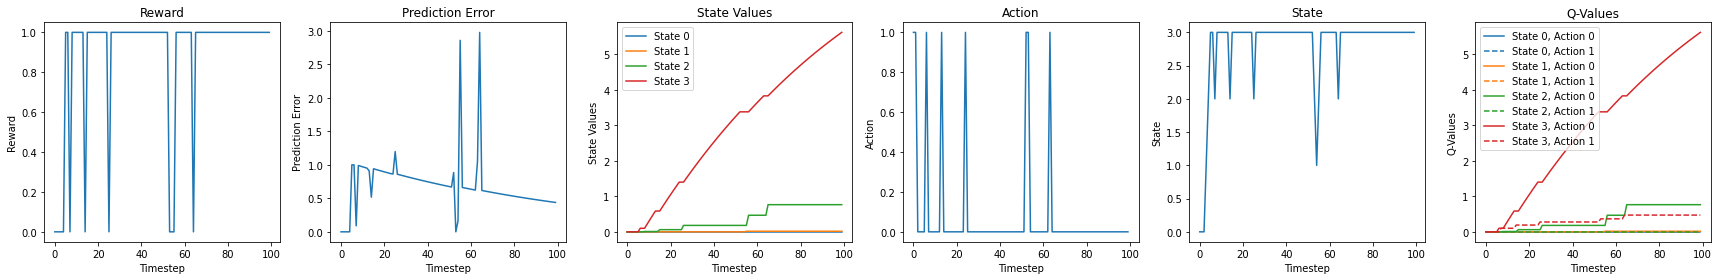

In [45]:
n_steps = 100  # number of steps in an episode
n_episodes = 1  # number of episodes (each new episode starts the agent over at the start state)

q_init = 0.
learning_rate = 0.1
epsilon = 0.1
discount = 0.9

env = FourStateLinearMDPEnv()
agent = QLearningTDAgent(env.n_states, env.n_actions, q_init=q_init, learning_rate=learning_rate, epsilon=epsilon, discount=discount)

data_to_plot = run_mdp_rl(env, agent, n_steps, n_episodes=n_episodes)
fig, axes = plotting.plot_learning_variables_over_time(
  data_to_plot, show_smooth=False, add_labels=True, window_size=10,
  stim_labels=[f'State {s}' for s in env.states], state_action_q_values=True)
plt.tight_layout()

### Plot environment and visitations

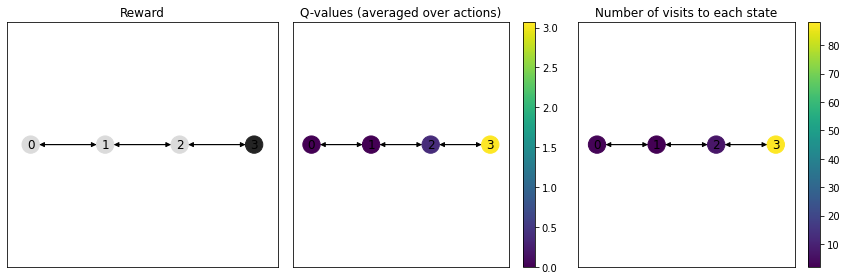

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
env.plot_env(ax=ax)
ax.set_title('Reward')

ax = axes[1]
agent.count_state_visits()
plotting.plot_graph(env.graph, env.pos_for_plotting, node_color=agent.q.mean(1),
                    cmap='viridis', vmin=None, vmax=None, ax=ax, cbar=True)
ax.set_title('Q-values (averaged over actions)')

ax = axes[2]
agent.count_state_visits()
plotting.plot_graph(env.graph, env.pos_for_plotting, node_color=agent.count_state_visits(),
                    cmap='viridis', vmin=None, vmax=None, ax=ax, cbar=True)
ax.set_title('Number of visits to each state')

plt.tight_layout()




#### Exercises
1. Which state, action emerges as the most valuable after training? Is that also the state that the agent visits the most?
2. What happens if you increase `epsilon` to 1?
3. What happens if you increase the number of episodes, `n_episodes`?
4. What happens if you decrease `discount` to 0?
4. Try replacing `env = FourStateLinearMDPEnv()` with `env = LinearMDPEnv(n_states)`, and vary the number of states. What effect does this have? You may need to increase `n_episodes`.



## Grid worlds. 
Here we will apply the same learning process but to a new and exciting class of MDPs: grid world. A grid world is an environment where states are arranged in a grid, which we will denote with an ascii map like the one below. This allows us to design maps. For example, the below map sets up an environment with a start state at the top left, a goal at the lower right, and a wall in between.

```
0S00P
00000
0XXX0
000G0
```

`S` denotes the starting state, `G` the goal, `P` denotes a punishment, `X` denotes an obstacle or boundary with, and `0` denotes states with no reward.


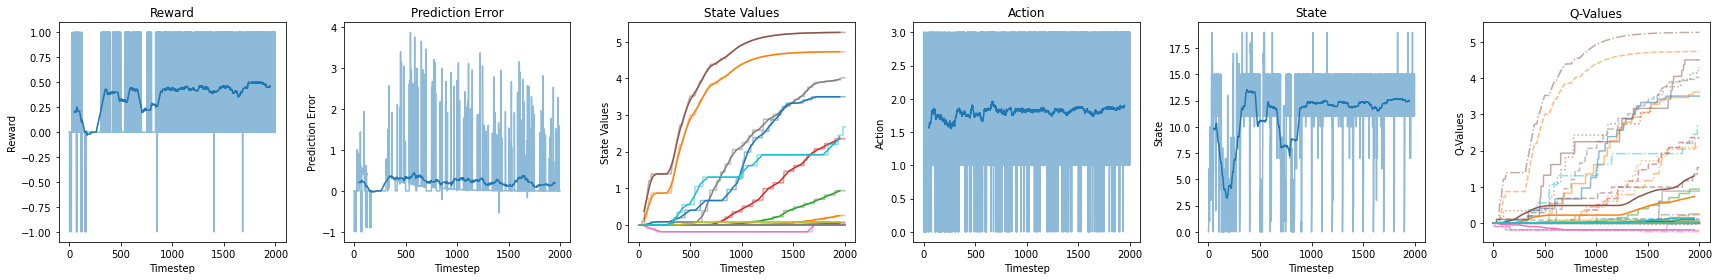

In [47]:
n_steps = 100
n_episodes = 20

map = """
0S000
00000
0P0X0
000G0
"""

# Specify how much reward (positive or negative) is associated with each symbol (besides 0, S, X)
reward_amounts = {'G': 1, 'P': -1}

# Set up environment.
arr = env_utils.map_to_array(map)
transitions, reward_amounts, start_state, pos = env_utils.arr_to_transition_dict(arr, reward_amounts)

env = MDPEnv(reward_amounts, transitions=transitions, start_state=start_state,
             absorb_states=None, pos_for_plotting=pos)
agent = QLearningTDAgent(env.n_states, env.n_actions, 0., learning_rate=0.1, epsilon=0.1, discount=.9)

data_to_plot = run_mdp_rl(env, agent, n_steps, n_episodes=n_episodes)
fig, axes = plotting.plot_learning_variables_over_time(
  data_to_plot, show_smooth=True, add_labels=False, window_size=100,
  stim_labels=[f'State {s}' for s in env.states], state_action_q_values=True)
plt.tight_layout()

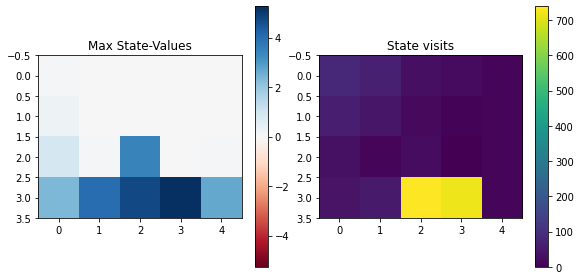

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes[0]
_, im = plotting.plot_grid_heatmap(env.pos_for_plotting, value=agent.q.max(1), ax=ax, cmap='RdBu', center_vaxis=True)
plt.colorbar(im, ax=ax)
ax.set_title('Max State-Values')

ax = axes[1]
_, im = plotting.plot_grid_heatmap(env.pos_for_plotting, value=agent.count_state_visits(), ax=ax, cmap='viridis')
plt.colorbar(im, ax=ax)
ax.set_title('State visits')

plt.tight_layout()


#### Exercise
1. What state does the agent find most rewarding? Is this also the state that the agent visits the most?
2. What happens when you increase the discount factor? Increase epsilon?
3. Edit the map to generate new gridworlds with different structures. Can you construct an environment that the agent cannot solve?

## Off-policy and On-policy Learning.

The final topic we will cover is on-policy versus off-policy learning.

Q-learning is an "off-policy" algorithm. It uses $\max_a Q(s_{t+1}, a)$, the maximum *possible* next value, rather than $Q(s_{t+1}, a_{t+1})$, the *actual* value of the observed next state. So essentially we are learning about a policy that is different from the one we are taking. This assumption is ok (intuitively) because the agent is still learning: we assume that eventually, it will be picking the best action.

Below, we'll implement an "on-policy" algorithm, which instead uses the *actual* next_action $Q(s_{t+1}, a_{t+1})$. This algorithm is called SARSA, which stands for state-action-reward-state-action, because it takes in `state`, `action`, `reward`, `next_state`, `next_action`, whereas Q-learning doesn't need `next_action` to be specified.

#### Exercise
Below we will implement a SARSA agent with the update:

$$
Q_{t+1}(s_t, a_t) \leftarrow Q_t(s_t, a_t) + \alpha \delta
$$

$$
\delta = r(s_t) + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t, a_t)
$$

In [49]:
class SARSATDAgent(QLearningTDAgent):
  """SARSA Agent """

  def __init__(self, n_states: int, n_actions: int, q_init: float,
               learning_rate: float, epsilon: float, discount: float, 
               name: str = 'SARSA TD Agent'):
    """Initialize.

    Args:
      n_states: number of states
      n_actions: number of actions
      q_init: initial value for each state, action pair.
      learning_rate: learning rate with which q-values are updated.
      epsilon: exploration parameter for epsilon-greedy
      discount: discount factor in [0, 1) range used to scale future reward
        (0 = only immediate reward matters, 0.999... = infinite planning horizon)
      name: name of agent class (default='Softmax SARSA TD Agent')
    """
    super().__init__(n_states=n_states, n_actions=n_actions, q_init=q_init, learning_rate=learning_rate,
                     epsilon=epsilon, discount=discount, name='Softmax SARSA TD Agent')
  
  def compute_prediction_error(self, state, action, reward, next_state, next_action):
    # # *Exercise*
    # # Get predicted value
    # predicted = ...

    # # Get actual value (reward + gamma * next_state_value)
    # actual = ...

    # # Compute the difference
    # td_error = ...

    # *Solution*
    # Get predicted value
    predicted = self.q[state, action]

    # Get actual value (reward + gamma * next_state_value)
    actual = reward + self.gamma * self.q[next_state, next_action]

    # Compute the difference
    td_error = actual - predicted

    return td_error


In [50]:
agent = SARSATDAgent(n_states=4, n_actions=2, q_init=0, learning_rate=0.1, epsilon=0.2, discount=0.9)
print(f'Initial agent.q, {agent.q}')

# state 1 -> 2, reward received
state = 1
action = 0
next_state = 2
next_action = 0
reward_12 = 1

prediction_error = agent.compute_prediction_error(
  state=state, action=action, reward=reward_12, next_state=next_state, next_action=next_action)
agent.update(state=state, action=action, reward=reward_12, next_state=next_state, next_action=next_action)
print('\nTransition from state 1 -> 2, R=1')
print(f'agent.q {agent.q}')
print(f'prediction_error {agent.prediction_error}')

# state 0 -> 1, no reward received
state = 0
action = 0
next_state = 1
next_action_01 = 0
reward_01 = 0

prediction_error = agent.compute_prediction_error(
  state=state, action=action, reward=reward_01, next_state=next_state, next_action=next_action_01)
agent.update(state=state, action=action, reward=reward, next_state=next_state, next_action=next_action_01)
print('\nTransition from state 0 -> 1, R=0')
print(f'agent.q {agent.q}')
print(f'prediction_error {agent.prediction_error}')


Initial agent.q, [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Transition from state 1 -> 2, R=1
agent.q [[0.  0. ]
 [0.1 0. ]
 [0.  0. ]
 [0.  0. ]]
prediction_error 1.0

Transition from state 0 -> 1, R=0
agent.q [[0.109 0.   ]
 [0.1   0.   ]
 [0.    0.   ]
 [0.    0.   ]]
prediction_error 1.09


#### Exercises
1. Confirm that the agent runs and is updating itself, and that (for these settings) the SARSA agent does the same thing that the Q-learning agent did (above). 
2. Change `next_action_01` to 1. What effect does this have on the prediction_error in the 0->1 transition?


### Cliff world
Often, SARSA and Q-learning will converge to pretty similar policies. But certain environments can be used to tease them apart. The cliff world is one such example.

<center><img src="./figures/cliff.png" width=500></center>

The cliff world contains a band of states with extremely low negative reward -- a "cliff", which if you go off of, will result in catastrophe. Walking along the cliff is the shortest path to reward, and a "confident" agent that assumes it will always take the optimal action and therefore will never walk off the cliff will deem this path optimal. An agent that is more realistic (or pessimistic) may not make this assumption, and might prefer the longer route.

Below, we will implement a simple cliff world, and train both of our agents (Q-learning and SARSA) to see how their policies differ!

Q-Learning TD Agent Total reward: -5109.0
Softmax SARSA TD Agent Total reward: 5631.0


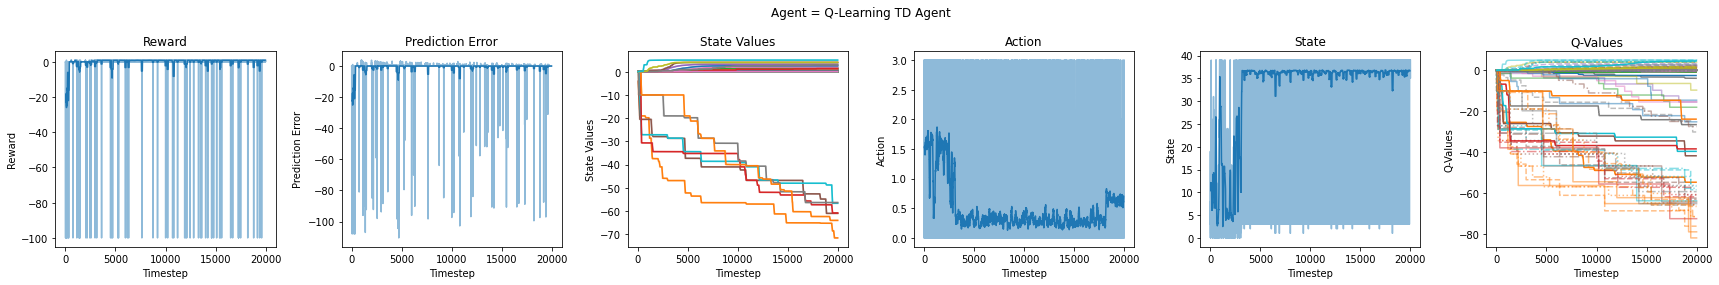

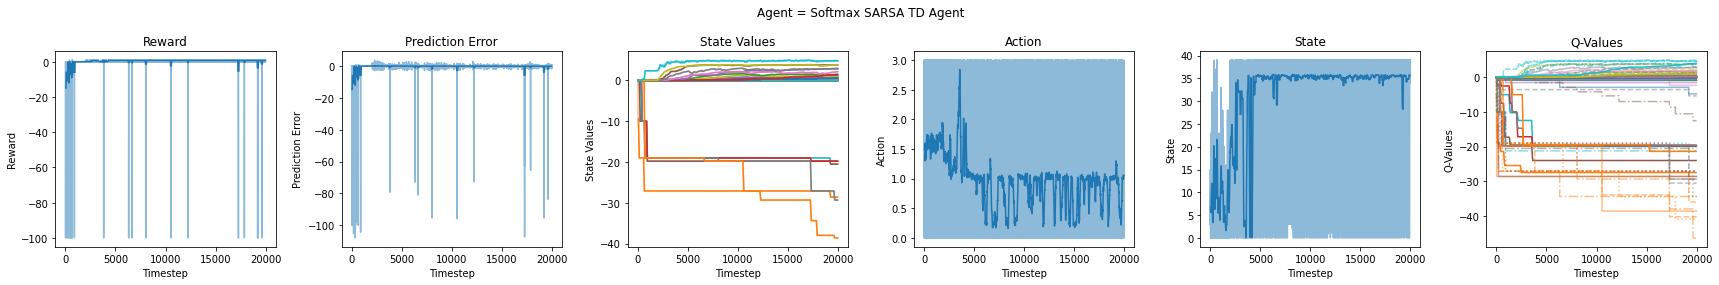

In [51]:
n_steps = 100
n_episodes = 200

map = """
0000000000
00XXXXXX00
0000000000
S0PPPPPP0G
"""

arr = env_utils.map_to_array(map)
transitions, reward_amounts, start_state, pos = env_utils.arr_to_transition_dict(
    arr, reward_symbols=['P', 'G'], reward_amounts={'P': -100, 'G': 1})

learning_rate = 0.1
epsilon = 0.1
discount=0.8

env = MDPEnv(reward_amounts, transitions=transitions, start_state=start_state, absorb_states=None, pos_for_plotting=pos)
q_agent = QLearningTDAgent(env.n_states, env.n_actions, q_init=q_init, learning_rate=learning_rate, epsilon=epsilon, discount=discount)
sarsa_agent = SARSATDAgent(env.n_states, env.n_actions, q_init=q_init, learning_rate=learning_rate, epsilon=epsilon, discount=discount)

agents = [q_agent, sarsa_agent]
for agent in agents:
  data_to_plot = run_mdp_rl(env, agent, n_steps, n_episodes=n_episodes)
  fig, axes = plotting.plot_learning_variables_over_time(
    data_to_plot, show_smooth=True, add_labels=False, window_size=100,
    stim_labels=[f'State {s}' for s in env.states], state_action_q_values=True)
  fig.suptitle(f'Agent = {agent.name}')
  print(f'{agent.name} Total reward: {agent.total_reward()}')

  plt.tight_layout()

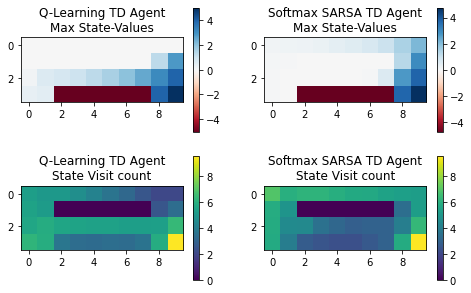

In [52]:
n_agents = len(agents)
fig, axes = plt.subplots(2, n_agents, figsize=(8, 5))

for i, agent in enumerate(agents):
  ax = axes[0, i]
  _, im = plotting.plot_grid_heatmap(env.pos_for_plotting, agent.q.max(1), cmap='RdBu', ax=ax, center_vaxis=True)
  plt.colorbar(im, ax=ax)
  ax.set_title(f'{agent.name}\nMax State-Values')

  ax = axes[1, i]
  _, im = plotting.plot_grid_heatmap(env.pos_for_plotting, np.log(agent.count_state_visits()+1), cmap='viridis', ax=ax)
  plt.colorbar(im, ax=ax)
  ax.set_title(f'{agent.name}\nState Visit count')



#### Exercise
1. Which route is preferred by each of the two agents?
2. Try increasing epsilon. What effect does this have on the policies?
3. Try increasing discount. What effect does this have on the policies?
4. Try making the punishment even lower. What happens?
5. (thought experiment) Which route is "better"? Is that well-defined?


# 4. Deep RL
While we have been working with "tabular" environments (environments that can be represented as tables with state, action entries), the same general methodology can be applied to neural networks.

<center><img src="./figures/deeprl.png" width=500></center>

We won't focus on that today, but if you want to get experience with that, you see our tutorial from Cosyne 2023:
* [lecture](https://www.youtube.com/watch?v=lJA2QP8ollI)
* [code](https://drive.google.com/file/d/1jEiDNA1q98n1Wrw_uBEFvpuV9BGW_yxW/view?usp=sharing)

# 5. Safety & Ethics
#### Discussion
What are some safety issues that arise in RL?
* **Alignment:** Think back to our earlier example ("How would you train a robot to make paperclips" from the beginning of the tutorial). This is a famous thought experiment called the paperclip problem from Nick Bostrom:
<center><img src="./figures/paperclip_problem.png" width=500></center>

* **Engagement:** Think back to our other earlier example about getting users to click on advertisements. Similar approaches are applied to get people to keep scrolling on social media, stay engaged in videos, and buy things. What are risks associated with this?

* **Safety:** Reinforcement learning works by trial-and-error. What are some settings in the real-world where this would be a bad idea? How would you mitigate it?



